# Predicting Kidney Transplant Allocation
### DATA1030 Fall 2022 Final Project
#### Lindsey Ross

## Loading in the data
**Source**: [Brazil Kidney Waitlist](https://www.kaggle.com/datasets/gustavomodelli/waitlist-kidney-brazil)

**About**: This dataset contains patient information for individuals registered on the waiting list of São Paulo State Organ Allocation System in Brazil between January 1, 2000 and December 29, 2017.

In [245]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt

df = pd.read_csv('../data/waitlist_kidney_brazil.csv', encoding='latin-1')

Many of the values in the dataset are written in Portugese, so they have to be translated to English:

In [246]:
df.replace(to_replace='Não', value='N', inplace=True)
df.replace(to_replace='Sim', value='Y', inplace=True)
df.replace(to_replace='Óbito Lista', value= 'DeathList', inplace=True)
df['age_cat'].replace(to_replace='18.a.60', value='From18to60', inplace=True)
df['age_cat'].replace(to_replace='Maior.60', value='Over60', inplace=True)
df['age_cat'].replace(to_replace='Menor.18', value='Below18', inplace=True)
df['cPRA_cat'].replace(to_replace='Entre_0_50', value='ZeroTo50', inplace=True)
df['cPRA_cat'].replace(to_replace='Entre_50_80', value='From50To80', inplace=True)
df['cPRA_cat'].replace(to_replace='Maior_80', value='Over80', inplace=True)
df.replace(to_replace='Outras', value='Other', inplace=True)
df.replace(to_replace='HAS', value='Hemolytic uremic syndrome (HUS)', inplace=True)
df.replace(to_replace='Diabetes', value='Diabetes', inplace=True)
df.replace(to_replace='GNC', value='Glumerulo-Nephrotic Syndrome (GNS)', inplace=True)
df.replace(to_replace='Pielonefrite', value='Pylonephritis (PN)', inplace=True)
df.replace(to_replace='heterozigoto', value='heterozygous', inplace=True)
df.replace(to_replace='homozigoto', value='homozygous', inplace=True)

df.rename(columns = {'anti.HBc':'HBc_antibodies', 'anti.HCV':'HCV_antibodies',
                    'underline_disease':'underlying_disease'}, inplace=True)

In [247]:
print(df['date_acutal'].value_counts())
print(df['priorization'].value_counts())
print(df['X36MthsTx'].value_counts())

43307    48153
Name: date_acutal, dtype: int64
N    48153
Name: priorization, dtype: int64
0    38276
1     9877
Name: X36MthsTx, dtype: int64


- Every value in date_acutal is 43307
- Every value in prioritization is N
- The X36MthsTx column is undocumented and redundant

These columns will be dropped. The Id column will also be dropped because it provides no meaning to the model.

In [248]:
df.drop(columns=['priorization'],inplace=True)
df.drop(columns=['date_acutal'],inplace=True)
df.drop(columns=['X36MthsTx'],inplace=True)
df.drop(columns=['Id'],inplace=True)

Investigating the similar features called 'Transplant' and 'Transplant_Y_N'

In [249]:
print(df['Transplant'].value_counts())
print(df['Transplant_Y_N'].value_counts())

N            25289
Y            13732
DeathList     9132
Name: Transplant, dtype: int64
N    34421
Y    13732
Name: Transplant_Y_N, dtype: int64


As we can see, Transplant_Y_N encompasses all of the information in the Transplant column and simplifies it into a simple classification problem with 2 classes: Yes or No. We will exclude the Transplant column because the 'DeathList' information is inconsistent with the number of deaths recorded elsewhere in the dataset. Transplant_Y_N will be the target variable for the classification problem, so the Transplant feaure will be dropped.

In [250]:
df.drop(columns=['Transplant'],inplace=True)

Investigating and cleaning the date feature.

In [251]:
print(df['date'].head())
df['date'] = pd.to_datetime(df['date'])
df['date'].info()

df['date_year'] = df['date'].dt.year
# print(df['date_year'].head(20))

df['date_month_num'] = df['date'].dt.month
# print(df['date_month_num'].head(20))

df['date_day'] = df['date'].dt.day
# print(df['date_day'].head(20))

df['date_dow'] = df['date'].dt.dayofweek
# print(df['date_dow'].head(20))

0    2017-06-29
1    2008-11-03
2    2010-07-13
3    2011-10-03
4    2006-07-05
Name: date, dtype: object
<class 'pandas.core.series.Series'>
RangeIndex: 48153 entries, 0 to 48152
Series name: date
Non-Null Count  Dtype         
--------------  -----         
48153 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 376.3 KB


Since we have turned the date feature into other, more useful features (year, month, day, and day of the week), we will drop the original date feature.

In [252]:
df.drop(columns=['date'],inplace=True)

## EDA

In [253]:
print(df.dtypes)

age_at_list_registration        int64
age_cat                        object
time_on_Dialysis              float64
race                           object
sex                            object
underlying_disease             object
diabetes                        int64
Blood_type                     object
number_transfusion              int64
gestation                      object
number_gestation              float64
prior_transplant               object
number_prior_transplant         int64
subregion                      object
cPRA                            int64
cPRA_cat                       object
HLA_A1                          int64
HLA_A2                          int64
HLA_B1                          int64
HLA_B2                          int64
HLA_DR1                         int64
HLA_DR2                         int64
DR_00                          object
B_00                           object
A_00                           object
calculated_frequency_DR.f1    float64
calculated_f

In [254]:
print(df.shape)

(48153, 51)


In [255]:
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values for each feature:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values for each feature:
time_on_Dialysis    0.027745
number_gestation    0.595788
chagas              0.083318
HCV_antibodies      0.083318
agHBs               0.083318
razon_removed       0.682367
dtype: float64


### We will consider a binary classification problem with this dataset
Research question: Can we develop a classification model that can predict whether a patient will receive a transplant or not?

Exploring the balance of the target variable:

N    34421
Y    13732
Name: Transplant_Y_N, dtype: int64
Percentage of patients who received a transplant or did not:
N    0.714826
Y    0.285174
Name: Transplant_Y_N, dtype: float64


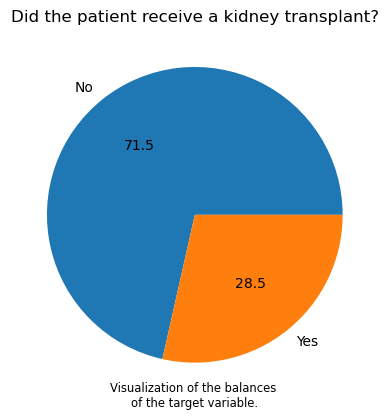

In [256]:
# Transplant_Y_N as the target variable
print(df['Transplant_Y_N'].value_counts())

print('Percentage of patients who received a transplant or did not:')
percent_transplants = df['Transplant_Y_N'].value_counts()/len(df)
print(percent_transplants)

caption = 'Visualization of the balances \n\
of the target variable.'

percent_transplants.plot.pie(labels=['No','Yes'],autopct='%.1f')
plt.title('Did the patient receive a kidney transplant?')
plt.ylabel('')
plt.savefig('../figures/pie_transplant_y_n.png',dpi=300)
plt.text(0,-1.3,caption,size='small',ha='center')
plt.show()

**Baseline accuracy**

The baseline accuracy of a classification model for this dataset is 0.714826.

#### Investigating the features

The dataset has information regarding 50 features of 48153 patients on the kidney waitlist.

Let's investigate how much time  a person spends on the waitlist before receiving a kidney transplant. There are two different columns that represent this information: 'time' or 'Time_Tx'. The 'time' column is measured in days whereas the 'Time_Tx' column is measured in months, but otherwise these two columns show the exact same information. Both 'time' and 'Time_Tx' are continuous features. 

Below are 2 visualizations depicting the time distribution.

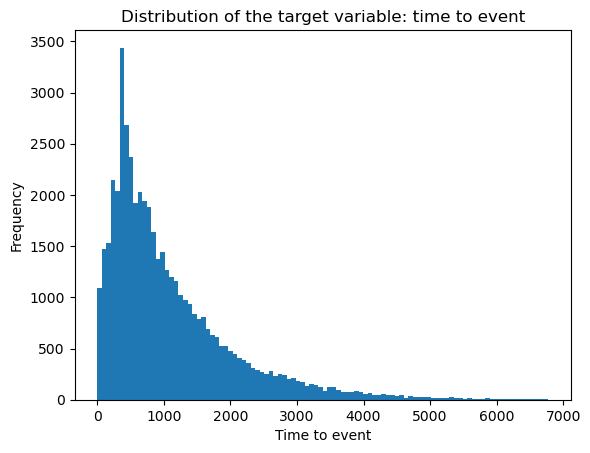

In [257]:
tv = 'time'
df[tv].plot.hist(bins=100)
plt.xlabel('Time to event')
plt.title('Distribution of the target variable: time to event')
plt.savefig('../figures/time_to_event_distribution.png',dpi=300)
plt.show()

Comparing the time to event (Time_Tx) and whether or not the patient received a transplant.

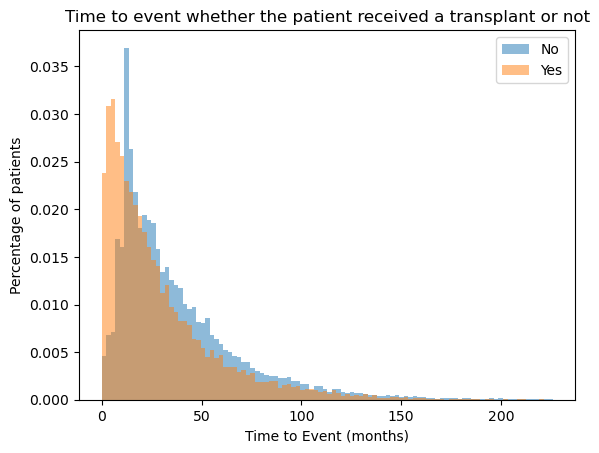

In [258]:
cats = df['Transplant_Y_N'].unique()
bin_range = (df['Time_Tx'].min(),df['Time_Tx'].max())

for c in cats:
    plt.hist(df[df['Transplant_Y_N']==c]['Time_Tx'],
             alpha=0.5,label=c,range=bin_range,
             bins=100,density=True)
plt.legend(['No', 'Yes'])
plt.ylabel('Percentage of patients')
plt.xlabel('Time to Event (months)')
plt.title('Time to event whether the patient received a transplant or not')
plt.savefig('../figures/time_to_event_transplant_y_n.png',dpi=300)
plt.show()

Now let's investigate the age_at_list_registration and age_cat features, first with simple plots showing the distribution of patients by age. The first bar plot shows the count of patients in each age category. The second histogram shows the distribution of ages of people on the waiting list.

From18to60    34752
Over60        11775
Below18        1626
Name: age_cat, dtype: int64


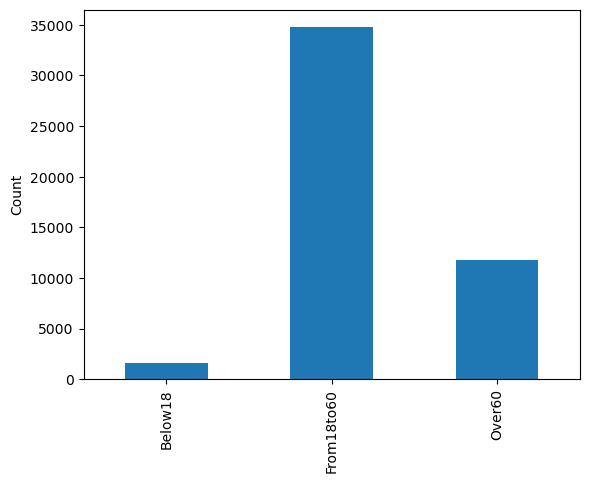

In [259]:
age_cat_order = ['Below18','From18to60','Over60']

print(df['age_cat'].value_counts())
df['age_cat'].value_counts().reindex(age_cat_order).plot.bar()
plt.ylabel('Count')
plt.savefig('../figures/age_category_barchart.png',dpi=300)
plt.show()

count    48153.000000
mean        48.613399
std         14.707031
min          0.000000
25%         39.000000
50%         50.000000
75%         59.000000
max         97.000000
Name: age_at_list_registration, dtype: float64


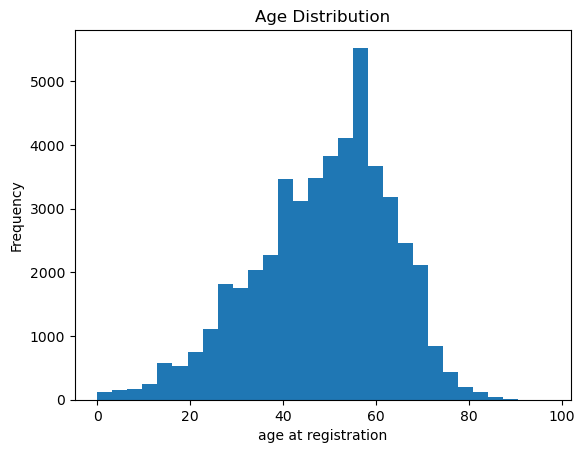

In [260]:
print(df['age_at_list_registration'].describe())
df['age_at_list_registration'].plot.hist(bins=30)
plt.xlabel('age at registration')
plt.title('Age Distribution')
plt.savefig('../figures/age_distribution.png',dpi=300)
plt.show()

Exploring the relationship between a person's age category and whether or not they receive a transplant:

In [261]:
count_matrix = df.groupby(['age_cat', 'Transplant_Y_N']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)

Transplant_Y_N      N      Y
age_cat                     
Below18           524   1102
From18to60      24241  10511
Over60           9656   2119
Transplant_Y_N         N         Y
age_cat                           
Below18         0.322263  0.677737
From18to60      0.697543  0.302457
Over60          0.820042  0.179958


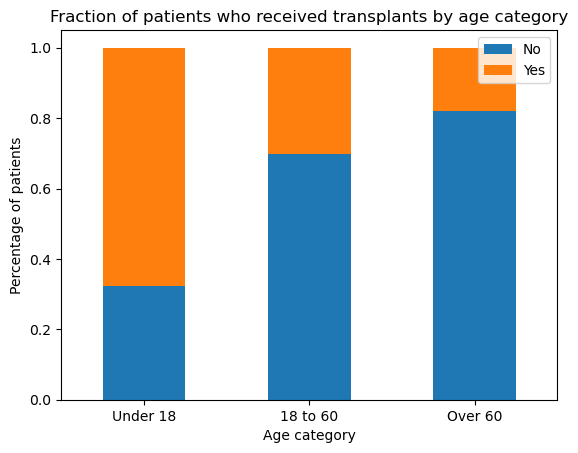

In [262]:
count_matrix_norm.plot.bar(stacked=True)
plt.xticks(ticks=np.arange(3),
           labels=['Under 18','18 to 60','Over 60'],
           rotation=0)
plt.xlabel('Age category')
plt.ylabel('Percentage of patients')
plt.title('Fraction of patients who received transplants by age category')
plt.legend(labels=['No', 'Yes'])
plt.savefig('../figures/transplant_y_n_by_age_cat.png',dpi=300)
plt.show()

Investigating the sex feature.

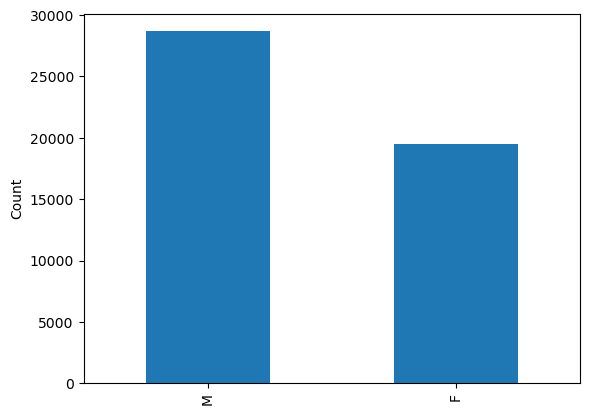

Percentage of patients by sex:
M    0.595685
F    0.404315
Name: sex, dtype: float64


In [263]:
df['sex'].value_counts().plot.bar()
plt.ylabel('Count')
plt.savefig('../figures/sex_barchart.png',dpi=300)
plt.show()
print('Percentage of patients by sex:')
print(df['sex'].value_counts()/len(df))

Investigating time_on_Dialysis.

count    46817.000000
mean        21.054254
std         29.212685
min          0.000000
25%          5.000000
50%         10.000000
75%         23.000000
max        180.000000
Name: time_on_Dialysis, dtype: float64
Number of missing values in the time on dialysis feature:
1336


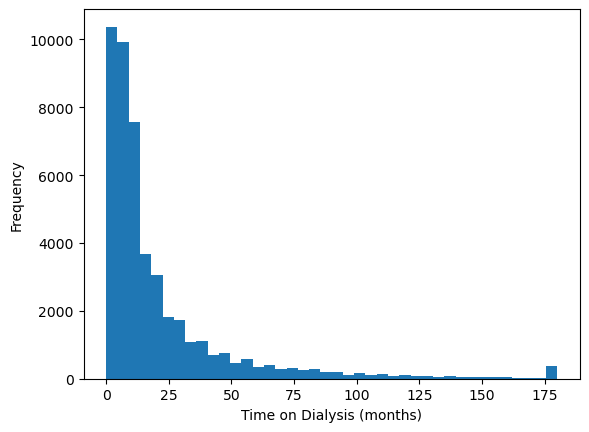

In [264]:
print(df['time_on_Dialysis'].describe())
na = df['time_on_Dialysis'].isnull()
print('Number of missing values in the time on dialysis feature:')
print(na.sum())
df['time_on_Dialysis'].plot.hist(bins=40)
plt.xlabel('Time on Dialysis (months)')
plt.savefig('../figures/time_on_dialysis_histogram.png',dpi=300)
plt.show()

Investigating the race feature.

Branca     32455
Parda       9032
Negra       5718
Amarela      948
Name: race, dtype: int64


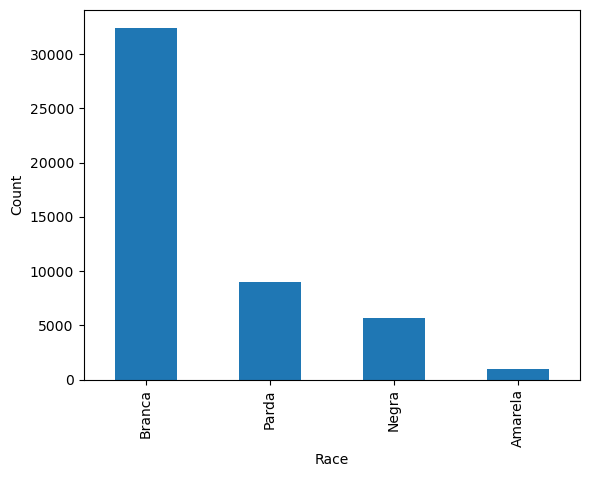

In [265]:
print(df['race'].value_counts())

df['race'].value_counts().plot.bar()
plt.xlabel('Race')
plt.ylabel('Count')
plt.savefig('../figures/race_barplot.png',dpi=300)
plt.show()

Investigating the underlying disease feature.

Other                                 16626
Hemolytic uremic syndrome (HUS)       13165
Diabetes                               9987
Glumerulo-Nephrotic Syndrome (GNS)     7234
Pylonephritis (PN)                     1141
Name: underlying_disease, dtype: int64


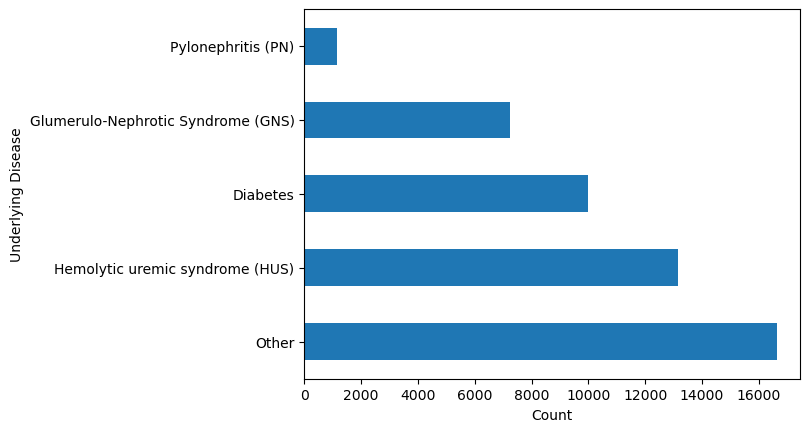

In [266]:
print(df['underlying_disease'].value_counts())

df['underlying_disease'].value_counts().plot.barh()
plt.ylabel('Underlying Disease')
plt.xlabel('Count')
plt.savefig('../figures/underlying_disease_barplot.png',dpi=300)
plt.show()

Investigating the diabetes feature.

In [267]:
print(df['diabetes'].value_counts())
print('38166 patients do NOT have diabetes.\n\
9987 patients have diabetes.')

1    38166
0     9987
Name: diabetes, dtype: int64
38166 patients do NOT have diabetes.
9987 patients have diabetes.


Investigating the blood type feature.

O     23640
A     16951
B      5834
AB     1728
Name: Blood_type, dtype: int64


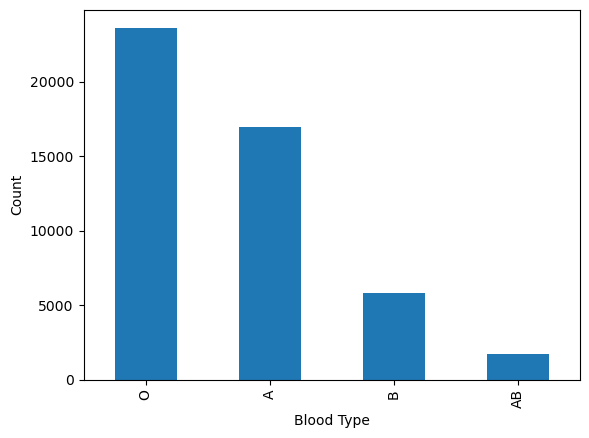

In [268]:
print(df['Blood_type'].value_counts())

df['Blood_type'].value_counts().plot.bar()
plt.xlabel('Blood Type')
plt.ylabel('Count')
plt.savefig('../figures/Blood_type_barplot.png',dpi=300)
plt.show()

Number of transfusions.

In [269]:
print(df['number_transfusion'].value_counts())

0    31398
1    14427
2     1547
3      781
Name: number_transfusion, dtype: int64


Gestation.

N    36122
Y    12031
Name: gestation, dtype: int64
N    0.750151
Y    0.249849
Name: gestation, dtype: float64


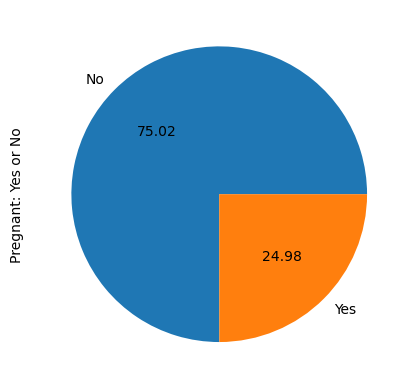

In [270]:
print(df['gestation'].value_counts())

percent_pregnant = df['gestation'].value_counts()/len(df)
print(percent_pregnant)
percent_pregnant.plot.pie(labels=['No','Yes'],autopct='%.2f')
plt.ylabel('Pregnant: Yes or No')
plt.savefig('../figures/pie_gestation.png',dpi=300)
plt.show()

number_gestation

In [271]:
print(df['number_gestation'].value_counts())
na_num_gest = df['number_gestation'].isnull()
print('Number of missing values in the number_gestation feature:')
print(na_num_gest.sum())

0.0     7433
2.0     3057
3.0     2891
1.0     2044
4.0     1606
5.0      942
6.0      543
7.0      319
8.0      222
10.0     143
9.0      113
11.0      49
12.0      32
13.0      26
14.0      19
17.0       6
15.0       5
16.0       5
18.0       3
63.0       1
35.0       1
41.0       1
22.0       1
20.0       1
24.0       1
Name: number_gestation, dtype: int64
Number of missing values in the number_gestation feature:
28689


prior_transplant

N    41983
Y     6170
Name: prior_transplant, dtype: int64
N    0.871867
Y    0.128133
Name: prior_transplant, dtype: float64


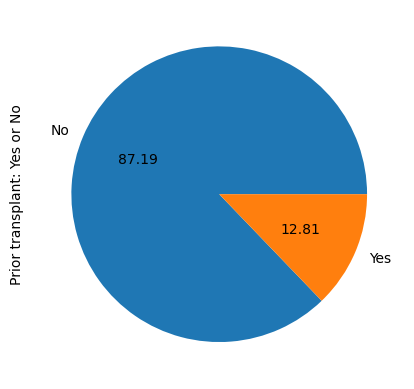

In [272]:
print(df['prior_transplant'].value_counts())

percent_prior_tx = df['prior_transplant'].value_counts()/len(df)
print(percent_prior_tx)
percent_prior_tx.plot.pie(labels=['No','Yes'],autopct='%.2f')
plt.ylabel('Prior transplant: Yes or No')
plt.savefig('../figures/pie_prior_transplant.png',dpi=300)
plt.show()

Number of prior transplants

In [273]:
print(df['number_prior_transplant'].value_counts())

0    41983
1     5428
2      630
3       94
4       14
5        4
Name: number_prior_transplant, dtype: int64


subregion

In [274]:
print(df['subregion'].value_counts())

UNIFESP    23166
HCFMUSP    13792
FUNDERP     7791
UNICAMP     3404
Name: subregion, dtype: int64


cPRA and cPRA_cat

count    48153.000000
mean        14.402093
std         29.119877
min          0.000000
25%          0.000000
50%          0.000000
75%          9.000000
max        100.000000
Name: cPRA, dtype: float64
Zero          34205
ZeroTo50       7311
Over80         3895
From50To80     2742
Name: cPRA_cat, dtype: int64


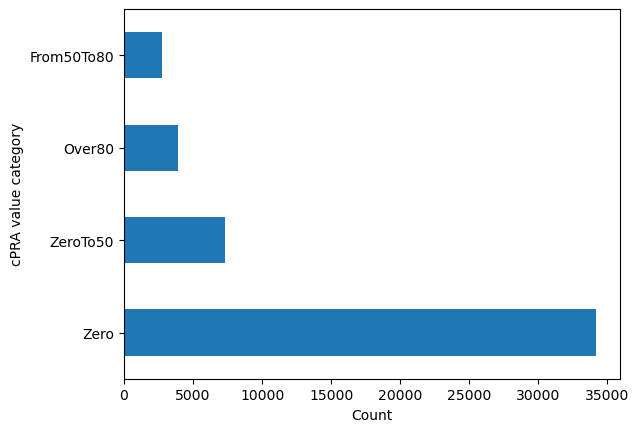

In [275]:
print(df['cPRA'].describe())
print(df['cPRA_cat'].value_counts())

df['cPRA_cat'].value_counts().plot.barh()
plt.xlabel('Count')
plt.ylabel('cPRA value category')
plt.savefig('../figures/cPRA_cat_barplot.png',dpi=300)
plt.show()

HLA_A1, HLA_A2, HLA_B1, HLA_B2, HLA_DR1, HLA_DR2

In [276]:
hla_feature = ['HLA_A1', 'HLA_A2', 'HLA_B1', 'HLA_B2', 'HLA_DR1', 'HLA_DR2']
for f in hla_feature:
    print(df[f].describe())

count    48153.000000
mean        10.359168
std         13.485239
min          0.000000
25%          2.000000
50%          2.000000
75%         23.000000
max         80.000000
Name: HLA_A1, dtype: float64
count    48153.000000
mean        28.816211
std         21.826129
min          0.000000
25%         11.000000
50%         29.000000
75%         33.000000
max         80.000000
Name: HLA_A2, dtype: float64
count    48153.000000
mean        25.750836
std         15.865324
min          0.000000
25%         14.000000
50%         18.000000
75%         40.000000
max         82.000000
Name: HLA_B1, dtype: float64
count    48153.000000
mean        41.148942
std         16.379271
min          0.000000
25%         35.000000
50%         44.000000
75%         51.000000
max         82.000000
Name: HLA_B2, dtype: float64
count    48153.000000
mean         5.986688
std          4.211553
min          0.000000
25%          3.000000
50%          4.000000
75%          9.000000
max         16.000000
Name

DR_00, B_00, A_00

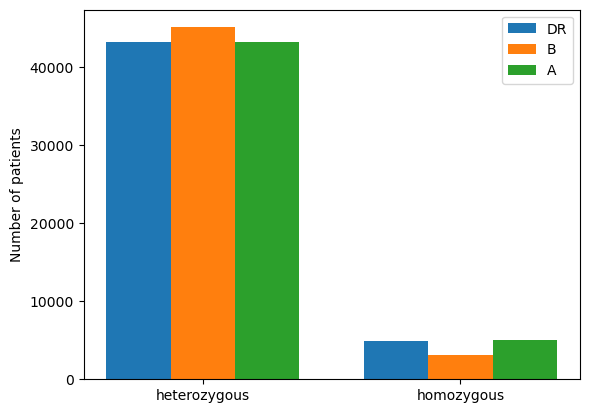

In [277]:
allele_feature = ['DR_00', 'B_00', 'A_00']

fig = plt.subplots()
barwidth = 0.25

bw1 = np.arange(2)
bw2 = [x + barwidth for x in bw1]
bw3 = [x + barwidth for x in bw2]

DR = df['DR_00'].value_counts()
B = df['B_00'].value_counts()
A = df['A_00'].value_counts()

plt.bar(bw1, DR, width=barwidth, label='DR')
plt.bar(bw2, B, width=barwidth, label='B')
plt.bar(bw3, A, width=barwidth, label='A')

plt.xticks([r + barwidth for r in range(2)], 
           ['heterozygous', 'homozygous'])
plt.ylabel('Number of patients')
plt.legend()
plt.savefig('../figures/DR_B_A_allele_barplot.png',dpi=300)
plt.show()

Investigating the 9 calculated_frequency features.    

In [278]:
calc_freq = ['calculated_frequency_DR.f1', 'calculated_frequency_DR.f2',
             'calculated_frequency_DR.f', 'calculated_frequency_B.f1',
             'calculated_frequency_B.f2', 'calculated_frequency_B.f', 
             'calculated_frequency_A.f1', 'calculated_frequency_A.f2',
             'calculated_frequency_A.f']
for f in calc_freq:
    print(df[f].describe())

count    48153.000000
mean         0.187804
std          0.059610
min          0.000000
25%          0.180000
50%          0.210000
75%          0.230000
max          0.250000
Name: calculated_frequency_DR.f1, dtype: float64
count    48153.000000
mean         0.170929
std          0.084097
min          0.000000
25%          0.070000
50%          0.210000
75%          0.230000
max          0.250000
Name: calculated_frequency_DR.f2, dtype: float64
count    48153.000000
mean         3.167426
std          1.917147
min          0.000000
25%          1.330000
50%          3.960000
75%          4.830000
max          6.250000
Name: calculated_frequency_DR.f, dtype: float64
count    48153.000000
mean         0.122476
std          0.064572
min          0.000000
25%          0.080000
50%          0.100000
75%          0.190000
max          0.210000
Name: calculated_frequency_B.f1, dtype: float64
count    48153.000000
mean         0.098659
std          0.068690
min          0.000000
25%          0

chagas                         

In [36]:
print(df['chagas'].value_counts())

N    44069
Y       72
Name: chagas, dtype: int64


HBc_antibodies,
HCV_antibodies, and
agHBs

In [37]:
print(df['HBc_antibodies'].value_counts())
print(df['HCV_antibodies'].value_counts())
print(df['agHBs'].value_counts())

N    47380
Y      773
Name: HBc_antibodies, dtype: int64
N    43595
Y      546
Name: HCV_antibodies, dtype: int64
N    44022
Y      119
Name: agHBs, dtype: int64


patient_still_on_list

In [38]:
print(df['patient_still_on_list'].value_counts())

N    37250
Y    10903
Name: patient_still_on_list, dtype: int64


death

N    36592
Y    11561
Name: death, dtype: int64
N    0.759911
Y    0.240089
Name: death, dtype: float64


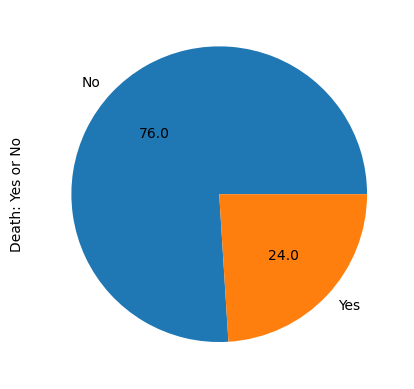

In [39]:
print(df['death'].value_counts())
percent_death = df['death'].value_counts()/len(df)
print(percent_death)
percent_death.plot.pie(labels=['No','Yes'],autopct='%.1f')
plt.ylabel('Death: Yes or No')
plt.savefig('../figures/pie_death.png',dpi=300)
plt.show()

Time_death

count    48153.000000
mean        75.726372
std         57.602143
min          0.000000
25%         27.000000
50%         61.000000
75%        112.000000
max        226.000000
Name: Time_death, dtype: float64


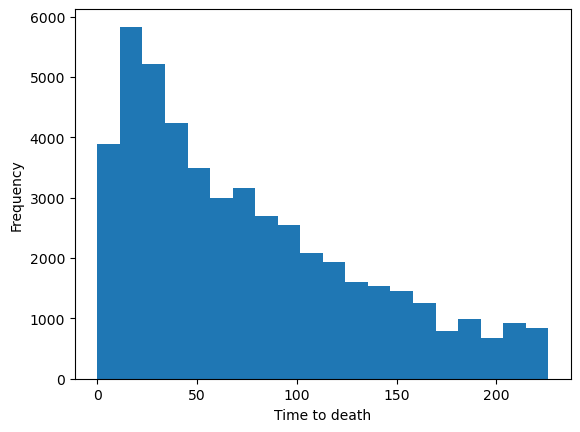

In [40]:
print(df['Time_death'].describe())
df['Time_death'].plot.hist(bins=20)
plt.xlabel('Time to death')
plt.savefig('../figures/time_death_histogram.png',dpi=300)
plt.show()

removed_list

In [41]:
print(df['removed_list'].value_counts())

N    32858
Y    15295
Name: removed_list, dtype: int64


razon_removed

In [42]:
print(df['razon_removed'].value_counts())

Removido (suspenso > 365 dias)     12985
Transferido para outro Estado        662
Não quer ser transplantado           592
Removido sem condições clínicas      412
Removido pela equipe                 254
Função renal recuperada              212
Abandonou o tratamento                93
Removido administrativo               62
Removido (inscrição duplicada)        17
Transferido de Equipe                  6
Name: razon_removed, dtype: int64
15295


Investigating the event feature. There was very little documentation on this dataset, and the meaning of the event feature is unknown. Below, I attempt to determine what each value in the event feature means.

In [43]:
print(df['event'].value_counts())

# determining what the events mean - comparing event to deaths
print(df[df['event']==0]['death'].value_counts())
print(df[df['event']==1]['death'].value_counts())
print(df[df['event']==2]['death'].value_counts())
print(df[df['event']==3]['death'].value_counts())

3    14356
1    13732
0    10933
2     9132
Name: event, dtype: int64
N    10933
Name: death, dtype: int64
N    11303
Y     2429
Name: death, dtype: int64
Y    9132
Name: death, dtype: int64
N    14356
Name: death, dtype: int64


In [44]:
# comparing event to Transplant_Y_N
print(df[df['event']==0]['Transplant_Y_N'].value_counts())
print(df[df['event']==1]['Transplant_Y_N'].value_counts())
print(df[df['event']==2]['Transplant_Y_N'].value_counts())
print(df[df['event']==3]['Transplant_Y_N'].value_counts())

N    10933
Name: Transplant_Y_N, dtype: int64
Y    13732
Name: Transplant_Y_N, dtype: int64
N    9132
Name: Transplant_Y_N, dtype: int64
N    14356
Name: Transplant_Y_N, dtype: int64


Based on this information, we can infer the following about the event feature:
- When event = 0 or event = 3, the patient did not receive a transplant and they did not die
- When event = 1, the patient received a transplant and they may have lived or died
- When event = 2, the patient did not receive a transplant and they died

Comparing cPRA to Transplant_Y_N with a violin plot.

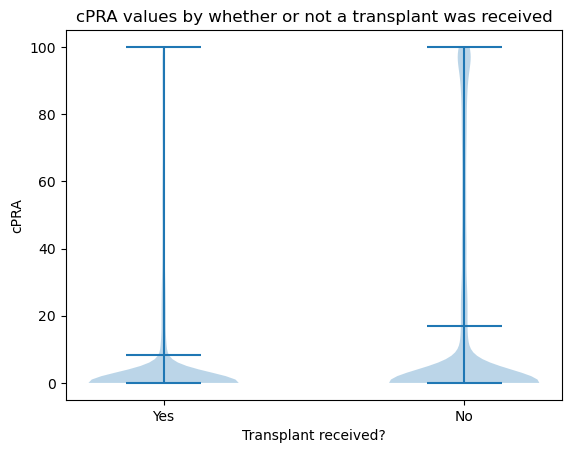

In [45]:
dataset = [df[df['Transplant_Y_N']=='Y']['cPRA'].values,
           df[df['Transplant_Y_N']=='N']['cPRA'].values]

plt.violinplot(dataset = dataset, showmeans=True)
plt.xticks([1,2],['Yes','No'])
plt.ylabel('cPRA')
plt.xlabel('Transplant received?')
plt.title('cPRA values by whether or not a transplant was received')
plt.savefig('../figures/violin_transplant_by_cPRA.png',dpi=300)
plt.show()

Comparing cPRA values to sex with a violin plot.

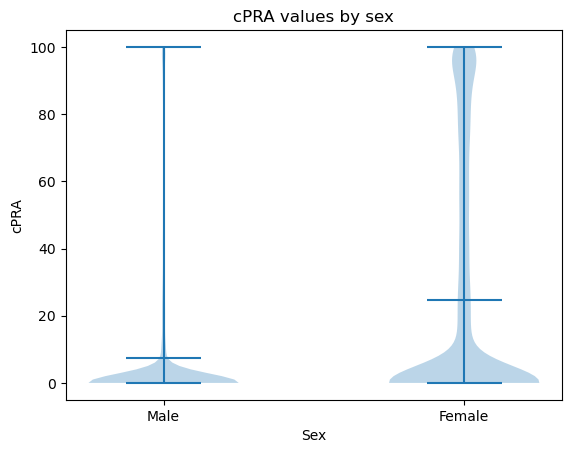

In [46]:
dataset = [df[df['sex']=='M']['cPRA'].values,
           df[df['sex']=='F']['cPRA'].values]

plt.violinplot(dataset = dataset, showmeans=True)
plt.xticks([1,2],['Male','Female'])
plt.ylabel('cPRA')
plt.xlabel('Sex')
plt.title('cPRA values by sex')
plt.savefig('../figures/violin_sex_by_cPRA.png',dpi=300)
plt.show()

Based off of the above violin plot, we might assume that more males receive kidney transplants than females on this list. That is because a lower cPRA value makes a person a better transplant candidate, and males have a lower average cPRA value than females in this dataset. 

Let's investigate this prediction.

In [47]:
sex_count_matrix = df.groupby(['sex', 'Transplant_Y_N']).size().unstack()
print(sex_count_matrix)
sex_count_matrix_norm = sex_count_matrix.div(sex_count_matrix.sum(axis=1),axis=0)
print(sex_count_matrix_norm)

Transplant_Y_N      N     Y
sex                        
F               14204  5265
M               20217  8467
Transplant_Y_N         N         Y
sex                               
F               0.729570  0.270430
M               0.704818  0.295182


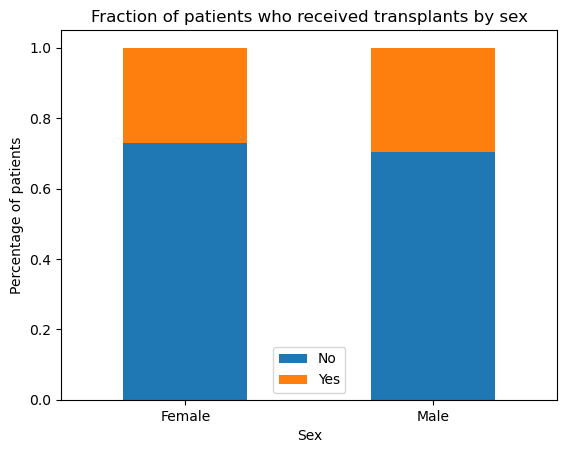

In [48]:
sex_count_matrix_norm.plot.bar(stacked=True)
plt.xticks(ticks=np.arange(2),
           labels=['Female','Male'],
           rotation=0)
plt.xlabel('Sex')
plt.ylabel('Percentage of patients')
plt.title('Fraction of patients who received transplants by sex')
plt.legend(labels=['No', 'Yes'])
plt.savefig('../figures/transplant_y_n_by_sex.png',dpi=300)
plt.show()

As shown, a slightly higher percentage of males (29.5%) receive transplants than the percentage of females who receive transplants (27.0%). 

### Data Preprocessing

The dataset is IID and it does not have group structure. Each patient on the waitlist only occupies one row of the dataset. This is not time-series data.

Before preprocessing, we must drop any features that we will not have for a new patient added to the waitlist. The goal of this ML model is to be able to predict whether a new patient added to this kidney transplant waitlist will receive a transplant or not at some point. In order to train the model properly for real-life use, we must only consider features of the dataset that will be available for any new patient on the day that they are added to the list. Any features that do not fit this condition will be dropped.

In [50]:
# list of features to drop because they won't exist for a new patient
to_drop = ['patient_still_on_list','death','Time_death','Time_Tx',
           'removed_list','razon_removed','time','event',
           'calculated_frequency_DR.f1','calculated_frequency_DR.f2',
           'calculated_frequency_DR.f','calculated_frequency_B.f1',
           'calculated_frequency_B.f2','calculated_frequency_B.f',
           'calculated_frequency_A.f1','calculated_frequency_A.f2',
           'calculated_frequency_A.f']
df.drop(columns=to_drop,inplace=True)

In [51]:
from sklearn.model_selection import train_test_split 

# separating feature matrix X from target variable y
y = df['Transplant_Y_N']
X = df.loc[:, df.columns != 'Transplant_Y_N']

random_state = 42

# train-test-split to isolate training set
X_train, X_other, y_train, y_other = train_test_split(
    X,y,train_size=0.8,random_state=random_state)

# train-test-split to separate training and validation sets
X_val, X_test, y_val, y_test = train_test_split(
    X_other,y_other,train_size = 0.5,random_state=random_state)

print('training set:',X_train.shape,y_train.shape) # 80% of points are in training
print('validation set:',X_val.shape,y_val.shape) # 10% of points are in validation
print('test set:',X_test.shape,y_test.shape) # 10% of points are in testing

training set: (38522, 33) (38522,)
validation set: (4815, 33) (4815,)
test set: (4816, 33) (4816,)


- Apply MinMaxEncoder or StandardScaler on the continuous features
- Apply OneHotEncoder or OrdinalEncoder on categorical and ordinal features

In [52]:
# making lists to contain the continuous, ordinal, and categorical features
continuous_features = ['age_at_list_registration','time_on_Dialysis',
                       'number_transfusion','number_gestation','cPRA',
                       'HLA_A1','HLA_A2','HLA_B1','HLA_B2','HLA_DR1',
                       'HLA_DR2','number_prior_transplant','date_year',
                       'date_month_num','date_day','date_dow']

ordinal_features = ['age_cat','cPRA_cat']
ordinal_cats = [['Below18','From18to60','Over60'],
                ['Zero','ZeroTo50','From50To80','Over80']]

categorical_features = ['race','sex','underlying_disease','diabetes','Blood_type',
                        'gestation','prior_transplant','subregion','DR_00',
                        'B_00','A_00','chagas','HBc_antibodies','HCV_antibodies',
                        'agHBs']

# checking to ensure the feature lists are the same length as the feature matrix
num_features_in_lists = len(continuous_features) + len(ordinal_features) + len(categorical_features)
print('Number of continuous features:',len(continuous_features))
print('Number of ordinal features:',len(ordinal_features))
print('Number of categorical features:',len(categorical_features))
print('Number of features in lists:',num_features_in_lists)
print('Number of features in X:',X.shape[1])

Number of continuous features: 16
Number of ordinal features: 2
Number of categorical features: 15
Number of features in lists: 33
Number of features in X: 33


In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

random_state = 42

# one-hot encoder
# We need to replace the NaN with a string
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary',sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, continuous_features),
    ('cat', categorical_transformer, categorical_features),
    ('ord', ordinal_transformer, ordinal_features)])

In [54]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# the feature names after fit
ftr_names = preprocessor.get_feature_names_out()

# converting the numpy array back to a data frame
df_train_preprocessed = pd.DataFrame(data=X_prep,columns=ftr_names)
print(df_train_preprocessed.shape)

# transforming the validation set
X_val_prep = preprocessor.transform(X_val)
df_val_preprocessed = pd.DataFrame(data=X_val_prep,columns = ftr_names)
print(df_val_preprocessed.shape)

# transforming the test set
X_test_prep = preprocessor.transform(X_test)
df_test_preprocessed = pd.DataFrame(data=X_test_prep,columns = ftr_names)
print(df_test_preprocessed.shape)
print(ftr_names)

(38522, 52)
(4815, 52)
(4816, 52)
['num__age_at_list_registration' 'num__time_on_Dialysis'
 'num__number_transfusion' 'num__number_gestation' 'num__cPRA'
 'num__HLA_A1' 'num__HLA_A2' 'num__HLA_B1' 'num__HLA_B2' 'num__HLA_DR1'
 'num__HLA_DR2' 'num__number_prior_transplant' 'num__date_year'
 'num__date_month_num' 'num__date_day' 'num__date_dow' 'cat__race_Amarela'
 'cat__race_Branca' 'cat__race_Negra' 'cat__race_Parda' 'cat__sex_M'
 'cat__underlying_disease_Diabetes'
 'cat__underlying_disease_Glumerulo-Nephrotic Syndrome (GNS)'
 'cat__underlying_disease_Hemolytic uremic syndrome (HUS)'
 'cat__underlying_disease_Other'
 'cat__underlying_disease_Pylonephritis (PN)' 'cat__diabetes_1'
 'cat__Blood_type_A' 'cat__Blood_type_AB' 'cat__Blood_type_B'
 'cat__Blood_type_O' 'cat__gestation_Y' 'cat__prior_transplant_Y'
 'cat__subregion_FUNDERP' 'cat__subregion_HCFMUSP'
 'cat__subregion_UNICAMP' 'cat__subregion_UNIFESP' 'cat__DR_00_homozygous'
 'cat__B_00_homozygous' 'cat__A_00_homozygous' 'cat__chaga

There are 52 features in the preprocessed data. Let's visualize a correlation matrix to understand feature correlations.

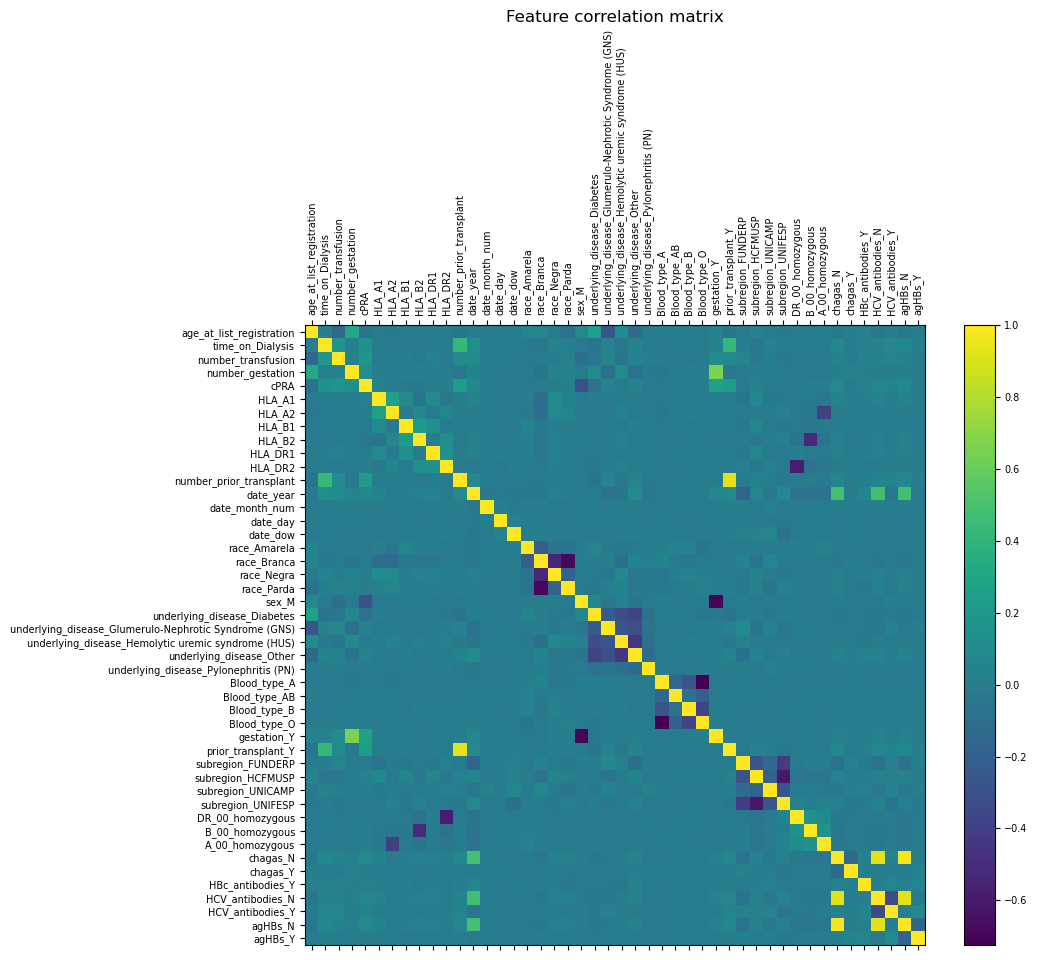

In [241]:
cm = df_train_preprocessed.corr()

plt.rcParams.update({'font.size': 7})

# plot correlation matrix
f = plt.figure(figsize=(10,10))
plt.matshow(cm,fignum=f.number)
labels = [x[5:] for x in df_train_preprocessed.columns]
plt.xticks(range(df_train_preprocessed.shape[1]), labels, rotation=90)
plt.yticks(range(df_train_preprocessed.shape[1]), labels)
plt.colorbar(shrink=0.8)
plt.rcParams.update({'font.size': 10})
plt.title('Feature correlation matrix')
plt.savefig('../figures/preprocessed_ftr_corr_matrix.png',dpi=300)
plt.show()

In [244]:
pd.set_option('display.max_columns', None)
display(cm)
pd.reset_option('display.max_columns')

,num__age_at_list_registration,num__time_on_Dialysis,num__number_transfusion,num__number_gestation,num__cPRA,num__HLA_A1,num__HLA_A2,num__HLA_B1,num__HLA_B2,num__HLA_DR1,num__HLA_DR2,num__number_prior_transplant,num__date_year,num__date_month_num,num__date_day,num__date_dow,cat__race_Amarela,cat__race_Branca,cat__race_Negra,cat__race_Parda,cat__sex_M,cat__underlying_disease_Diabetes,cat__underlying_disease_Glumerulo-Nephrotic Syndrome (GNS),cat__underlying_disease_Hemolytic uremic syndrome (HUS),cat__underlying_disease_Other,cat__underlying_disease_Pylonephritis (PN),cat__Blood_type_A,cat__Blood_type_AB,cat__Blood_type_B,cat__Blood_type_O,cat__gestation_Y,cat__prior_transplant_Y,cat__subregion_FUNDERP,cat__subregion_HCFMUSP,cat__subregion_UNICAMP,cat__subregion_UNIFESP,cat__DR_00_homozygous,cat__B_00_homozygous,cat__A_00_homozygous,cat__chagas_N,cat__chagas_Y,cat__HBc_antibodies_Y,cat__HCV_antibodies_N,cat__HCV_antibodies_Y,cat__agHBs_N,cat__agHBs_Y
num__age_at_list_registration,1.000000,0.004462,-0.153645,0.317416,-0.080862,-0.008367,-0.033995,-0.010390,0.009593,-0.001095,0.002820,-0.054317,-0.011169,-0.004316,0.001859,-0.006108,0.063945,0.058541,-0.013562,-0.082068,0.089724,0.263296,-0.263100,0.113326,-0.125806,-0.018805,0.016664,0.013922,0.000460,-0.021426,0.046671,-0.055815,-0.013887,0.049856,-0.013717,-0.027743,-0.001420,-0.005214,0.010900,-0.047375,0.015503,0.025503,-0.045219,0.005939,-0.045132,0.000567
num__time_on_Dialysis,0.004462,1.000000,0.172993,0.033447,0.154073,0.011703,0.006107,0.008354,-0.010055,0.015873,-0.002644,0.433463,0.125136,0.011223,0.003898,0.009097,-0.023351,-0.041752,0.043421,0.022300,-0.023824,-0.062633,0.041634,-0.029503,0.049922,0.000765,-0.010230,0.002850,-0.000652,0.009149,0.040801,0.426832,0.014170,-0.039801,0.035772,0.006730,0.001433,0.006660,-0.002917,0.080148,0.003963,0.035702,0.049337,0.076108,0.077225,0.017859
num__number_transfusion,-0.153645,0.172993,1.000000,0.047158,0.183870,0.008573,0.002512,0.021153,-0.023354,0.027926,-0.015064,0.106486,0.115608,0.014978,0.008878,0.004961,-0.013618,-0.020765,0.004553,0.026070,-0.090605,-0.048811,0.062974,-0.055375,0.039250,0.020909,-0.001791,-0.004945,-0.006223,0.007611,0.104435,0.099491,0.062157,-0.032923,0.018506,-0.025706,-0.004726,-0.000761,-0.016515,0.048033,0.004241,0.039402,0.025604,0.057295,0.046747,0.009331
num__number_gestation,0.317416,0.033447,0.047158,1.000000,0.122839,0.010087,0.003326,0.014434,0.017182,0.016582,0.001706,-0.034254,0.055541,0.010928,0.008732,-0.010163,-0.021414,-0.057019,0.052402,0.032603,-0.015156,0.088160,-0.090135,0.090623,-0.077237,-0.010363,-0.025186,0.002836,0.015225,0.013038,0.662921,-0.034579,-0.017074,0.019028,-0.002631,-0.003501,-0.008649,-0.005595,-0.009197,0.016606,0.025423,0.010821,0.019615,0.000198,0.020026,0.002530
num__cPRA,-0.080862,0.154073,0.183870,0.122839,1.000000,0.030119,0.008946,-0.010265,-0.031516,0.008903,0.015572,0.225460,0.081913,0.001426,0.008785,0.002103,-0.016905,-0.014477,0.008968,0.016034,-0.290198,-0.078043,0.046079,-0.016742,0.045560,0.005747,-0.012078,0.002918,-0.002516,0.012114,0.271123,0.221375,-0.009085,0.027290,-0.000576,-0.017662,0.008449,0.022266,0.012993,0.087830,0.006228,0.025858,0.068048,0.045358,0.086839,0.008057
num__HLA_A1,-0.008367,0.011703,0.008573,0.010087,0.030119,1.000000,0.265252,0.089250,-0.053839,0.102378,-0.036634,0.006513,0.055977,0.000447,-0.006947,-0.004403,0.016136,-0.109514,0.111625,0.033307,-0.003951,0.011732,-0.017086,0.007524,0.001182,-0.016606,-0.013456,0.003720,0.009879,0.005052,0.012549,0.008008,-0.053861,0.083120,-0.025565,-0.022170,-0.017710,-0.004437,-0.035825,0.044431,0.014410,0.012383,0.043012,0.003196,0.045139,0.005921
num__HLA_A2,-0.033995,0.006107,0.002512,0.003326,0.008946,0.265252,1.000000,-0.021101,0.074785,-0.010393,0.069159,0.002914,0.006388,-0.002467,-0.010322,-0.002832,-0.041545,-0.102931,0.097363,0.057918,-0.013362,-0.016975,-0.004743,0.040216,-0.019240,-0.001368,-0.026797,-0.003229,0.018658,0.014680,0.000880,0.004145,-0.008752,-0.022212,

#### Removing highly correlated features

- age_cat is highly correlated with age_at_list_registration
    - age_cat will be removed because it contains essentially the same information as age_at_list_registration, but with less detail
- cPRA_cat is highly correlated with cPRA
    - cPRA_cat will be removed because it contains the same information as cPRA, but with less detail
- cat_chagas_nan 
    - has a perfect positive correlation with cat_HCV_antibodies_nan
    - has a perfect positive correlation with cat_agHBs
    - has a correlation coefficient of -0.9906 with cat_chagas_N
- cat_diabetes_1
    - has a perfect negative correlation with cat_Underlying_disease_diabetes

In [57]:
prepped_ftrs_to_drop = ['ord__cPRA_cat', 'cat__diabetes_1', 
                        'cat__HCV_antibodies_nan', 'cat__agHBs_nan',
                        'cat__chagas_nan', 'ord__age_cat']

In [58]:
df_train_preprocessed.drop(columns=prepped_ftrs_to_drop, inplace=True)
df_val_preprocessed.drop(columns=prepped_ftrs_to_drop, inplace=True)
df_test_preprocessed.drop(columns=prepped_ftrs_to_drop, inplace=True)

In [59]:
# print(df_train_preprocessed.columns)
print(len(df_train_preprocessed.columns))
print(len(df_val_preprocessed.columns))
print(len(df_test_preprocessed.columns))

46
46
46


In [174]:
# saving the preprocessed feature matrices to the /data folder
df_train_preprocessed.to_csv('../data/preprocessed_training_data.csv')
df_val_preprocessed.to_csv('../data/preprocessed_validation_data.csv')
df_test_preprocessed.to_csv('../data/preprocessed_testing_data.csv')

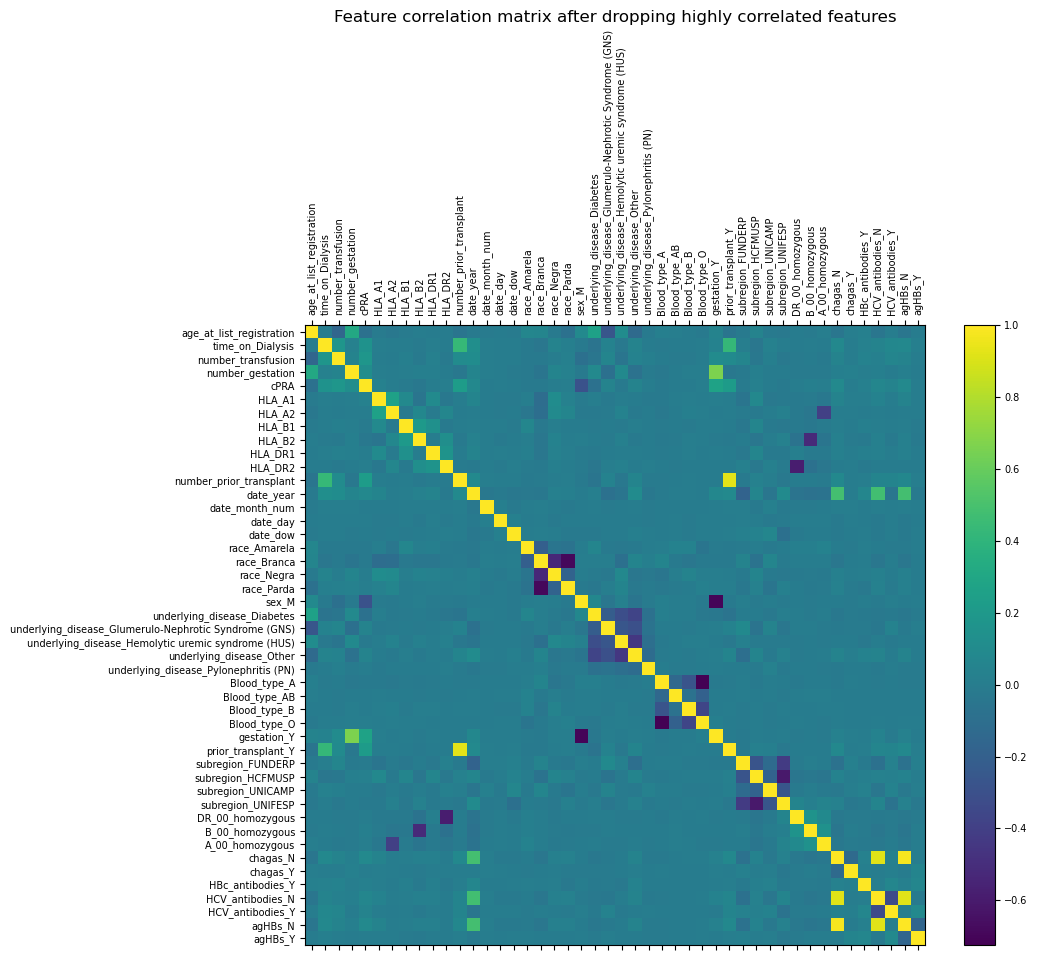

In [60]:
cm = df_train_preprocessed.corr()

plt.rcParams.update({'font.size': 7})

# plot correlation matrix
f = plt.figure(figsize=(10,10))
plt.matshow(cm,fignum=f.number)
labels = [x[5:] for x in df_train_preprocessed.columns]
plt.xticks(range(df_train_preprocessed.shape[1]), labels, rotation=90)
plt.yticks(range(df_train_preprocessed.shape[1]), labels)
plt.colorbar(shrink=0.8)
plt.rcParams.update({'font.size': 10})
plt.title('Feature correlation matrix after dropping highly correlated features')
plt.savefig('../figures/preprocessed_ftr_corr_matrix_after_dropping.png',dpi=300)
plt.show()

### Determining the baseline test score
I will investigate f1, f0.5, and accuracy scores for this model. Below I determine the baseline f1, f0.5, and accuracy scores for one sample test set. Within the ML pipeline below, I re-determine these baseline values. This is just a preliminary investigation to get a sense of the values we are working with.

Rationale to try f0.5 score:
- It is expensive to act on a positive prediction from this model. We do not want a large fraction of the predicted positives to be false positives due to the ethical implications of promising someone a kidney without being able to follow through.
    - Precision or fbeta with beta < 1 (f0.5 is often used)

In [61]:
# finding the baseline f1 / f0.5 score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score


print('Percentage of patients who received a transplant or did not:')
print(percent_transplants)

# f1 score
baseline_all_yes_y_test = ['Y']*len(y_test)
# print(baseline_all_yes_y_test)
baseline_test_f1 = f1_score(
    y_test,baseline_all_yes_y_test,pos_label='Y')
print('The baseline f1 score is:',baseline_test_f1)
baseline_test_f_pt5 = fbeta_score(
    y_test,baseline_all_yes_y_test,beta=0.5,pos_label='Y')
print('The baseline f0.5 score is:',baseline_test_f_pt5)
print('The baseline accuracy score is:',percent_transplants.iloc[0])

Percentage of patients who received a transplant or did not:
N    0.714826
Y    0.285174
Name: Transplant_Y_N, dtype: float64
The baseline f1 score is: 0.45739910313901344
The baseline f0.5 score is: 0.3450608930987822
The baseline accuracy score is: 0.7148256598758125


## Training and Testing ML Models

First, I will build a general function that takes in any feature matrix, target variable, initialized ML algorithm, and a parameter grid, and outputs a list of the best models and their test scores for 10 different random states. The function performs KFold cross-validation with 5 folds using GridSearchCV in order to determine the best set of hyperparameters for each model.

The code below creates a custom column dropper transformer to use in my ML pipeline. I adapted this code from [this StackOverflow post](https://stackoverflow.com/questions/68402691/adding-dropping-column-instance-into-a-pipeline). I adapted code from [this post](https://datascience.stackexchange.com/questions/75449/is-there-a-way-to-force-a-transformer-to-return-a-pandas-dataframe) for the 'pandarizer' in my pipeline.

In [63]:
# creating a custom column dropper

class columnDropTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
# from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer

def MLpipe_KFold_F1(X,y,preprocessor,ml_algo,param_grid):
    '''This function splits X and y into other/test (80/20)
       and then applies KFold with 5 folds to other. The 
       logloss metric is minimized in cross-validation.'''
    
    f1_test_scores = []
    f5_test_scores = []
    acc_scores = []
    best_models = []
    baseline_f1_scores = []
    baseline_f5_scores = []
    baseline_acc_scores = []
    
    # number of random states
    nr_states = 5
    
    # fix param_grid to have the correct keys for the Pipeline
    new_param_grid = {}
    for k in param_grid.keys():
        new_k = 'model__'+k
        new_param_grid[new_k] = param_grid[k]
        
    print(new_param_grid)
    
    for i in range(nr_states):
        r = 42*i
        print('-----------------------------------------')
        print('Random state = {}'.format(r))
        
        new_param_grid['model__random_state'] = [r]
        
        # splitting the feature matrix into other and test
        X_other, X_test, y_other, y_test = train_test_split(
            X,y,train_size=0.8,random_state=r
        )
        
        # KFold splitter for _other (5 folds)
        kfold = KFold(n_splits=5,shuffle=True,random_state=r)
        
        # make pipeline
        pipe = Pipeline(steps=[('prep',preprocessor),
                               ('pandarizer',FunctionTransformer(
                                   lambda x: pd.DataFrame(x,columns=ftr_names))),
                               ('columnDropper',columnDropTransformer(
                                   prepped_ftrs_to_drop)),
                               ('model',ml_algo)])
        
        if str(ml_algo) == 'LinearSVC()':
            scorer = 'accuracy'
        else:
            scorer = 'neg_log_loss'
            
        print('Scoring based on:',scorer)
        
        # perform cross validation with GridSearchCV
        grid = GridSearchCV(pipe,param_grid=new_param_grid,
                            scoring=scorer,
                            cv=kfold,return_train_score = True)
        grid.fit(X_other, y_other)
        
        # print the mean validation score of the best estimator
        print('validation score:',grid.best_score_)
        
        # print the best model parameters
        print('best model parameters:',grid.best_params_)
        
        # save the model
        best_models.append(grid.best_estimator_)
        
        # calculate the baseline f1 score for the test set
        all_yes = ['Y']*len(y_test)
        baseline_test_f1 = f1_score(y_test,all_yes,pos_label='Y')
        print('The baseline f1 score is:',baseline_test_f1)
        baseline_f1_scores.append(baseline_test_f1)
        
        # calculate the f1 score on the test set
        y_test_pred = best_models[-1].predict(X_test)
        test_fone_score = f1_score(y_test,y_test_pred,pos_label='Y')
        f1_test_scores.append(test_fone_score)
        print('f1 test score:',test_fone_score)
        
        # calculate the baseline f0.5 score for the test set
        baseline_test_fptfive = fbeta_score(y_test,all_yes,beta=0.5,pos_label='Y')
        print('The baseline f0.5 score is:',baseline_test_fptfive)
        baseline_f5_scores.append(baseline_test_fptfive)
        
        # calculate the f0.5 score on the test set
        test_fptfive = fbeta_score(y_test,y_test_pred,beta=0.5,pos_label='Y')
        f5_test_scores.append(test_fptfive)
        print('f0.5 test score:',test_fptfive)
        
        # calculate the baseline accuracy score
        baseline_acc = (y_test.value_counts()/len(y_test)).iloc[0]
        baseline_acc_scores.append(baseline_acc)
        print('baseline accuracy:',baseline_acc)

        # calculate the accuracy score
        test_acc_score = accuracy_score(y_test,y_test_pred)
        acc_scores.append(test_acc_score)
        print('test accuracy score:',test_acc_score)
    
    return best_models, f1_test_scores, f5_test_scores, acc_scores, baseline_f1_scores, baseline_f5_scores, baseline_acc_scores
    

#### Revisiting missing values

In [92]:
print('fraction of missing values for each feature:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values for each feature:
time_on_Dialysis    0.027745
number_gestation    0.595788
chagas              0.083318
HCV_antibodies      0.083318
agHBs               0.083318
razon_removed       0.682367
dtype: float64


time_on_dialysis, number_gestation are the continuous features with missing values. For every ML model besides XGBoost, missing values in continuous features will generate an error message. Therefore, I will create a new preprocessor to use on the dataset when I am not using XGBoost to handle these missing values. I will replace all the missing values with 0s because for time_on_Dialysis, a missing values just means that the person has not had any dialysis, so they would have spent 0 days on dialysis. Number_gestation indicates gestational age for pregnant women, so a missing value just means that the person is either a male or a non-pregnant female. Therefore, we can say that they are at 0 days of gestational age. It would not make sense to perform mean, median, or multivariate imputation to replace these values.

### Logistic Regression

In [86]:
from sklearn.impute import SimpleImputer

# new preprocessor with an imputer to get rid of missing values in continuous features

impute_numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(
        missing_values=np.nan,strategy='constant',fill_value=0)),
    ('scaler', StandardScaler())])

# collect the transformers
impute_preprocessor = ColumnTransformer(transformers=[
    ('num', impute_numeric_transformer, continuous_features),
    ('cat', categorical_transformer, categorical_features),
    ('ord', ordinal_transformer, ordinal_features)])

In [89]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

alpha = np.logspace(-7,2,12)

log_reg_param_grid = {'penalty': ['none','l1','l2'],
                      'C': 1/alpha,
                      'solver': ['saga']}

LogReg = LogisticRegression(max_iter=5000)

best_models_lr, f1_scores_lr, f5_scores_lr, acc_scores_lr, baseline_f1_lr, baseline_f5_lr,baseline_acc_lr = MLpipe_KFold_F1(
    X,y,impute_preprocessor,LogReg,log_reg_param_grid)

{'model__penalty': ['none', 'l1', 'l2'], 'model__C': array([1.00000000e+07, 1.51991108e+06, 2.31012970e+05, 3.51119173e+04,
       5.33669923e+03, 8.11130831e+02, 1.23284674e+02, 1.87381742e+01,
       2.84803587e+00, 4.32876128e-01, 6.57933225e-02, 1.00000000e-02]), 'model__solver': ['saga']}
-----------------------------------------
Random state = 0
Scoring based on: neg_log_loss
validation score: -0.5355771095404188
best model parameters: {'model__C': 0.4328761281083052, 'model__penalty': 'l2', 'model__random_state': 0, 'model__solver': 'saga'}
The baseline f1 score is: 0.44911433172302745
f1 test score: 0.3278517358392065
The baseline f0.5 score is: 0.33754508266163197
f0.5 test score: 0.45134397010205546
baseline accuracy: 0.7104142871975911
test accuracy score: 0.7326342020558613
-----------------------------------------
Random state = 42
Scoring based on: neg_log_loss
validation score: -0.5327962270768436
best model parameters: {'model__C': 0.4328761281083052, 'model__penalty': 

In [230]:
# import pickle
# file = open('../results/LogReg_results.save', 'wb')
# pickle.dump((best_models_lr,f1_scores_lr,
#              f5_scores_lr,acc_scores_lr,
#              baseline_f5_lr,baseline_acc_lr),
#             file)
# file.close()

In [231]:
# to open the saved info from pickle:

# import pickle
# file = open('results/LogReg_results.save', 'rb')
# best_models_lr,f1_scores_lr,f5_scores_lr,acc_scores_lr,baseline_f5_lr,baseline_acc_lr = pickle.load(file)
# file.close()

### Random Forest Classification

In [93]:
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {'n_estimators': [200],
                 'max_depth': [1,3,5,7,10,30,50,70,100],
                 'max_features': np.linspace(0.1,1,10)}

RF = RandomForestClassifier()

best_models_rf, f1_scores_rf, f5_scores_rf, acc_scores_rf,baseline_f1_rf,baseline_f5_rf,baseline_acc_rf = MLpipe_KFold_F1(
    X,y,impute_preprocessor,RF,rf_param_grid)

{'model__n_estimators': [200], 'model__max_depth': [1, 3, 5, 7, 10, 30, 50, 70, 100], 'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}
-----------------------------------------
Random state = 0
Scoring based on: neg_log_loss
validation score: -0.5130396068780672
best model parameters: {'model__max_depth': 10, 'model__max_features': 0.6, 'model__n_estimators': 200, 'model__random_state': 0}
The baseline f1 score is: 0.44911433172302745
f1 test score: 0.29943820224719103
The baseline f0.5 score is: 0.33754508266163197
f0.5 test score: 0.45377149667972083
baseline accuracy: 0.7104142871975911
test accuracy score: 0.7410445436610944
-----------------------------------------
Random state = 42
Scoring based on: neg_log_loss
validation score: -0.5117455144947046
best model parameters: {'model__max_depth': 10, 'model__max_features': 0.5, 'model__n_estimators': 200, 'model__random_state': 42}
The baseline f1 score is: 0.4563231287065235
f1 test score: 0.27843137

### Support Vector Classifier

With a linear kernel.

In [94]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

linsvc_param_grid = {'penalty': ['l1','l2'],
                     'loss': ['squared_hinge'],
                     'C': np.logspace(-3,3,num=7),
                     'max_iter':[150000],
                     'dual':[False]}

LinearSVC = LinearSVC()

best_models_svc, f1_scores_svc, f5_scores_svc, acc_scores_svc,baseline_f1_svc,baseline_f5_svc,baseline_acc_svc = MLpipe_KFold_F1(
    X,y,impute_preprocessor,LinearSVC,linsvc_param_grid)

{'model__penalty': ['l1', 'l2'], 'model__loss': ['squared_hinge'], 'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'model__max_iter': [150000], 'model__dual': [False]}
-----------------------------------------
Random state = 0
Scoring based on: accuracy
validation score: 0.7301802278058441
best model parameters: {'model__C': 0.01, 'model__dual': False, 'model__loss': 'squared_hinge', 'model__max_iter': 150000, 'model__penalty': 'l1', 'model__random_state': 0}
The baseline f1 score is: 0.44911433172302745
f1 test score: 0.2706512545813363
The baseline f0.5 score is: 0.33754508266163197
f0.5 test score: 0.41230029204604024
baseline accuracy: 0.7104142871975911
test accuracy score: 0.7313882255217526
-----------------------------------------
Random state = 42
Scoring based on: accuracy
validation score: 0.7328279501854131
best model parameters: {'model__C': 0.01, 'model__dual': False, 'model__loss': 'squared_hinge', 'model__max_iter': 150000, 'model__penalty':

### XGBoost Classifier


- The `early_stopping_rounds` parameter used below will help XGBoost stop the execution to prevent overfitting
    - `early_stopping_rounds=75` will tell XGBoost to stop training a new model with new number of trees if the next 75 trees see no improvement in the validation test score
    - because of this, I was able to set `n_estimators` in the parameter grid to be an arbitrarily large number
    
[Here](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier) is the documentation for XGBoost.

In [100]:
import xgboost
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings("ignore")

nr_states = 5

xgb_param_grid = {"learning_rate": [0.03],
                  "n_estimators": [100000],
                  "missing": [np.nan],
                  "max_depth": [3,5,10,30,100],
                  "colsample_bytree": np.linspace(0.7,1,num=4),              
                  "subsample": np.linspace(.65,1,num=5)}

best_models_xgb = []
test_accuracies_xgb = []
test_f1_xgb = []
test_fpt5_xgb = []
test_sets_xgb = []
baseline_f1_xgb = []
baseline_fpt5_xgb = []
baseline_accs_xgb = []

for i in range(nr_states):
    r = 42*i
    print('-----------------------------')
    print('Random state = {}'.format(r))
    
    # basic splitting
    X_train, X_other, y_train, y_other = train_test_split(
        X,y,train_size=0.6,random_state=r)
    X_val, X_test, y_val, y_test = train_test_split(
        X_other,y_other,train_size=0.5,random_state=r)
    
    # transform the training set
    X_train_prep = preprocessor.fit_transform(X_train)
    ftr_names = preprocessor.get_feature_names_out()
    df_train = pd.DataFrame(data=X_train_prep,columns=ftr_names)

    # transform the CV
    X_val_prep = preprocessor.transform(X_val)
    df_val = pd.DataFrame(data=X_val_prep,columns=ftr_names)

    # transform the test
    X_test_prep = preprocessor.transform(X_test)
    df_test = pd.DataFrame(data=X_test_prep,columns=ftr_names)
    
    # drop highly correlated feature
    df_train.drop(columns=prepped_ftrs_to_drop, inplace=True)
    df_val.drop(columns=prepped_ftrs_to_drop, inplace=True)
    df_test.drop(columns=prepped_ftrs_to_drop, inplace=True)
    
    # initiate the xgboost model
    xgb = xgboost.XGBClassifier(random_state=r)
    pg = ParameterGrid(xgb_param_grid)
    scores = np.zeros(len(pg))
    
    for i in range(len(pg)):
        params = pg[i]
        xgb.set_params(**params)
        eval_set = [(df_val, y_val)]
        xgb.fit(df_train,
                y_train,
                early_stopping_rounds=75,
                eval_set=eval_set,
                eval_metric='logloss',
                verbose=False)
        y_val_pred = xgb.predict(df_val,
                                 iteration_range=(0,xgb.best_iteration+1))
        scores[i] = accuracy_score(y_val,y_val_pred)

    best_params = np.array(pg)[scores == np.max(scores)]
    
    print('Validation set max score and best parameters are:')
    print(np.max(scores))
    print(best_params)
    
    # using the best parameters within the model on the test set
    xgb.set_params(**best_params[0])
    xgb.fit(df_train,y_train,
            early_stopping_rounds=75,
            eval_set=eval_set,
            eval_metric='logloss',
            verbose=False)
    y_test_pred = xgb.predict(df_test,
                              iteration_range=(0,xgb.best_iteration+1))
    
    # append the best model to the list
    best_models_xgb.append(xgb)
    
    # calculate the test set accuracy score
    test_accuracies_xgb.append(accuracy_score(y_test,y_test_pred))
    print('test accuracy score:',accuracy_score(y_test,y_test_pred))
        
    # calculate the baseline f0.5 score for the test set
    all_yes = ['Y']*len(y_test)
    baseline_test_fptfive = fbeta_score(y_test,all_yes,beta=0.5,pos_label='Y')
    print('baseline f0.5 score:',baseline_test_fptfive)
    baseline_fpt5_xgb.append(baseline_test_fptfive)
    
    # calculate the test set f1 score
    f1_score_test = f1_score(y_test,y_test_pred,pos_label='Y')
    test_f1_xgb.append(f1_score_test)
    print('f1 test score:',f1_score_test)
    
    # calculate the baseline f1 score
    baseline_f1 = f1_score(y_test,all_yes,pos_label='Y')
    baseline_f1_xgb.append(baseline_f1)
    print('baseline f1 score:',baseline_f1)
    
    # calculate the test set f0.5 score
    f5_score_test = fbeta_score(y_test,y_test_pred,beta=0.5,pos_label='Y')
    test_fpt5_xgb.append(f5_score_test)
    print('f0.5 test score:',f5_score_test)
    
    # calculate the baseline accuracy score
    baseline_accuracy = (y_test.value_counts()/len(y_test)).iloc[0]
    baseline_accs_xgb.append(baseline_accuracy)
    print('baseline accuracy:',baseline_accuracy)
    
    df_test['y_true'] = np.array(y_test)
    test_sets_xgb.append(df_test)

-----------------------------
Random state = 0
Validation set max score and best parameters are:
0.7520506697123871
[{'colsample_bytree': 0.7999999999999999, 'learning_rate': 0.03, 'max_depth': 5, 'missing': nan, 'n_estimators': 100000, 'subsample': 0.825}]
test accuracy score: 0.7570345758488215
baseline f0.5 score: 0.33370478936020737
f1 test score: 0.4253438113948919
baseline f1 score: 0.4448570967221056
f0.5 test score: 0.5396983671943164
baseline accuracy: 0.7139445540442322
-----------------------------
Random state = 42
Validation set max score and best parameters are:
0.7582805523829301
[{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 3, 'missing': nan, 'n_estimators': 100000, 'subsample': 0.65}]
test accuracy score: 0.7481050773543765
baseline f0.5 score: 0.34250550088255916
f1 test score: 0.4226558781532604
baseline f1 score: 0.4545892169448011
f0.5 test score: 0.5343603321699363
baseline accuracy: 0.7058457065725262
-----------------------------
Random state = 

In [120]:
import pickle
file = open('../results/XGB_results.save', 'wb')
pickle.dump((best_models_xgb,test_accuracies_xgb,test_f1_xgb,
             test_fpt5_xgb,test_sets_xgb,baseline_f1_xgb,
             baseline_fpt5_xgb,baseline_accs_xgb),
            file)
file.close()

In [122]:
# to open the saved info from pickle:

import pickle
file = open('../results/XGB_results.save', 'rb')
best_models_xgb,test_accuracies_xgb,test_f1_xgb,test_fpt5_xgb,test_sets_xgb,baseline_f1_xgb,baseline_fpt5_xgb,baseline_accs_xgb= pickle.load(
    file)
file.close()

## ML Model Performance

### Logistic Regression

In [123]:
# OUTPUT: best_models_lr,f1_scores_lr,f5_scores_lr,acc_scores_lr,baseline_f5_lr,baseline_acc_lr

mean_lr_f5 = np.mean(f5_scores_lr)
print('Mean logistic regression f0.5 score:',mean_lr_f5)
std_lr_f5 = np.std(f5_scores_lr)
print('STD logistic regression f0.5 score:',std_lr_f5)
baseline_mean_lr_f5 = np.mean(baseline_f5_lr)
print('Mean logistic regression BASELINE f0.5 score:',baseline_mean_lr_f5)
baseline_std_lr_f5 = np.std(baseline_f5_lr)
print('STD logistic regression BASELINE f0.5 score:',baseline_std_lr_f5)

mean_lr_acc = np.mean(acc_scores_lr)
print('Mean logistic regression accuracy score:',mean_lr_acc)
std_lr_acc = np.std(acc_scores_lr)
print('STD logistic regression accuracy score:',std_lr_acc)
baseline_mean_lr_acc = np.mean(baseline_acc_lr)
print('Mean logistic regression BASELINE accuracy score:',baseline_mean_lr_acc)
baseline_std_lr_acc = np.std(baseline_acc_lr)
print('STD logistic regression BASELINE accuracy score:',baseline_std_lr_acc)

Mean logistic regression f0.5 score: 0.4286879206420645
STD logistic regression f0.5 score: 0.01327078159908564
Mean logistic regression BASELINE f0.5 score: 0.33661523309879227
STD logistic regression BASELINE f0.5 score: 0.0044455287202120304
Mean logistic regression accuracy score: 0.7269234762745302
STD logistic regression accuracy score: 0.005467882997500386
Mean logistic regression BASELINE accuracy score: 0.7112657044958987
STD logistic regression BASELINE accuracy score: 0.004090165616334824


### Random Forest Classification

In [124]:
# OUTPUT: best_models_rf, f1_scores_rf, f5_scores_rf, acc_scores_rf, baseline_f5_rf,baseline_acc_rf
mean_rf_f5 = np.mean(f5_scores_rf)
print('Mean random forest f0.5 score:',mean_rf_f5)
std_rf_f5 = np.std(f5_scores_rf)
print('STD random forest f0.5 score:',std_rf_f5)
baseline_mean_rf_f5 = np.mean(baseline_f5_rf)
print('Mean random forest BASELINE f0.5 score:',baseline_mean_rf_f5)
baseline_std_rf_f5 = np.std(baseline_f5_rf)
print('STD random forest BASELINE f0.5 score:',baseline_std_rf_f5)

mean_rf_acc = np.mean(acc_scores_rf)
print('Mean random forest accuracy score:',mean_rf_acc)
std_rf_acc = np.std(acc_scores_rf)
print('STD random forest accuracy score:',std_rf_acc)
baseline_mean_rf_acc = np.mean(baseline_acc_rf)
print('Mean random forest BASELINE accuracy score:',baseline_mean_rf_acc)
baseline_std_rf_acc = np.std(baseline_acc_rf)
print('STD random forest BASELINE accuracy score:',baseline_std_rf_acc)

Mean random forest f0.5 score: 0.4490081452097088
STD random forest f0.5 score: 0.024920654635478833
Mean random forest BASELINE f0.5 score: 0.33661523309879227
STD random forest BASELINE f0.5 score: 0.0044455287202120304
Mean random forest accuracy score: 0.7404423216696087
STD random forest accuracy score: 0.004738352635265854
Mean random forest BASELINE accuracy score: 0.7112657044958987
STD random forest BASELINE accuracy score: 0.004090165616334824


### Linear SVC

In [125]:
# OUTPUT: best_models_svc, f1_scores_svc, f5_scores_svc, acc_scores_svc, baseline_f5_svc,baseline_acc_svc

mean_svc_f5 = np.mean(f5_scores_svc)
print('Mean linear SVC f0.5 score:',mean_svc_f5)
std_svc_f5 = np.std(f5_scores_svc)
print('STD linear SVC f0.5 score:',std_svc_f5)
baseline_mean_svc_f5 = np.mean(baseline_f5_svc)
print('Mean linear SVC BASELINE f0.5 score:',baseline_mean_svc_f5)
baseline_std_svc_f5 = np.std(baseline_f5_svc)
print('STD linear SVC BASELINE f0.5 score:',baseline_std_svc_f5)

mean_svc_acc = np.mean(acc_scores_svc)
print('Mean linear SVC accuracy score:',mean_svc_acc)
std_svc_acc = np.std(acc_scores_svc)
print('STD linear SVC accuracy score:',std_svc_acc)
baseline_mean_svc_acc = np.mean(baseline_acc_svc)
print('Mean linear SVC BASELINE accuracy score:',baseline_mean_svc_acc)
baseline_std_svc_acc = np.std(baseline_acc_svc)
print('STD linear SVC BASELINE accuracy score:',baseline_std_svc_acc)

Mean linear SVC f0.5 score: 0.3956379919460005
STD linear SVC f0.5 score: 0.011154739143493058
Mean linear SVC BASELINE f0.5 score: 0.33661523309879227
STD linear SVC BASELINE f0.5 score: 0.0044455287202120304
Mean linear SVC accuracy score: 0.7265496833142976
STD linear SVC accuracy score: 0.004998421392031669
Mean linear SVC BASELINE accuracy score: 0.7112657044958987
STD linear SVC BASELINE accuracy score: 0.004090165616334824


### XGBoost Classifier

In [126]:
# OUTPUT: best_models_xgb, test_accuracies_xgb, test_f1_xgb, test_fpt5_xgb, test_sets_xgb, baseline_fpt5_xgb, baseline_accs_xgb

mean_xgb_f5 = np.mean(test_fpt5_xgb)
print('Mean XGB f0.5 score:',mean_xgb_f5)
std_xgb_f5 = np.std(test_fpt5_xgb)
print('STD XGB f0.5 score:',std_xgb_f5)
baseline_mean_xgb_f5 = np.mean(baseline_fpt5_xgb)
print('Mean XGB BASELINE f0.5 score:',baseline_mean_xgb_f5)
baseline_std_xgb_f5 = np.std(baseline_fpt5_xgb)
print('STD XGB BASELINE f0.5 score:',baseline_std_xgb_f5)

mean_xgb_acc = np.mean(test_accuracies_xgb)
print('Mean XGB accuracy score:',mean_xgb_acc)
std_xgb_acc = np.std(test_accuracies_xgb)
print('STD XGB accuracy score:',std_xgb_acc)
baseline_mean_xgb_acc = np.mean(baseline_accs_xgb)
print('Mean XGB BASELINE accuracy score:',baseline_mean_xgb_acc)
baseline_std_xgb_acc = np.std(baseline_accs_xgb)
print('STD XGB BASELINE accuracy score:',baseline_std_xgb_acc)


Mean XGB f0.5 score: 0.5232495239508739
STD XGB f0.5 score: 0.013069953610034924
Mean XGB BASELINE f0.5 score: 0.33455973944179507
STD XGB BASELINE f0.5 score: 0.004327420348590157
Mean XGB accuracy score: 0.7504724327691829
STD XGB accuracy score: 0.003820881842739591
Mean XGB BASELINE accuracy score: 0.7131554355726301
STD XGB BASELINE accuracy score: 0.003979655031457989


Table containing results for all ML algorithms:

| ML algo                      	| baseline accuracy	| test accuracy	| accuracy number of standard deviations above baseline |baseline f0.5 score| test f0.5 score |f0.5 number of standard deviations above baseline|
|------------------------------	|:-----------------:|:-------------:|:--------------------------------------------------------:|:----------------:|:----------------:|:-----------------------------------------------:|
| logistic regression  	|  0.711 +/- 0.00409| 0.727 +/- 0.00547| 3.912| 0.337 +/- 0.00445|0.429 +/- 0.0133|20.695| 
| random forest classification 	|0.711 +/- 0.00409|0.740 +/- 0.00474|7.133|0.337 +/- 0.00445|0.449 +/- 0.0249| 25.282| 
| linear SVM classification   	| 0.711 +/- 0.00409| 0.727 +/- 0.00500| 3.737|0.337 +/- 0.00445| 0.396 +/- 0.0112|13.277| 
| XGBoost classification |0.713 +/- 0.00398|0.750 +/- 0.00382|9.377|0.335 +/- 0.00433 | 0.523 +/- 0.0131|43.603| 

Plotting the mean and standard deviations of the test scores for the best models created from the 5 different ML algorithms tested above.

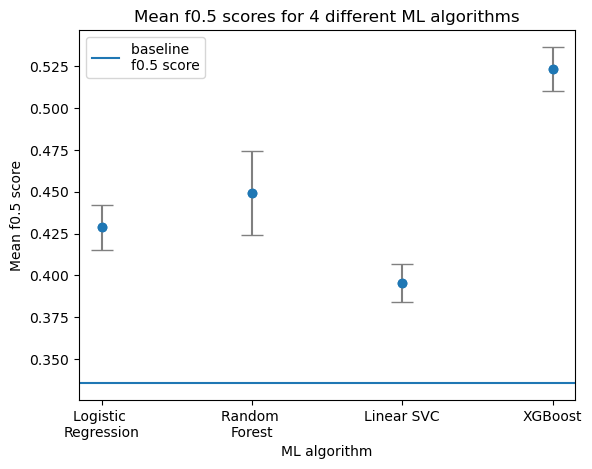

In [232]:
# see ps7 for plotting code

all_mean_f5s = [mean_lr_f5,mean_rf_f5,mean_svc_f5,mean_xgb_f5]
all_std_f5s = [std_lr_f5,std_rf_f5,std_svc_f5,std_xgb_f5]
labels = ['Logistic \nRegression','Random \nForest',
          'Linear SVC','XGBoost']

baseline_f5_score_avg = np.mean([baseline_mean_lr_f5,
                                 baseline_mean_rf_f5,
                                 baseline_mean_svc_f5,
                                 baseline_mean_xgb_f5])

plt.scatter(labels,all_mean_f5s)
plt.errorbar(labels,all_mean_f5s,yerr=all_std_f5s,fmt='o',ecolor='grey',capsize=8)
plt.axhline(baseline_f5_score_avg,label='baseline \nf0.5 score')
plt.ylabel('Mean f0.5 score')
plt.xlabel('ML algorithm')
plt.title('Mean f0.5 scores for 4 different ML algorithms')
plt.legend()
plt.savefig('../figures/mean_std_f5_all_models.png',dpi=300)
plt.show()

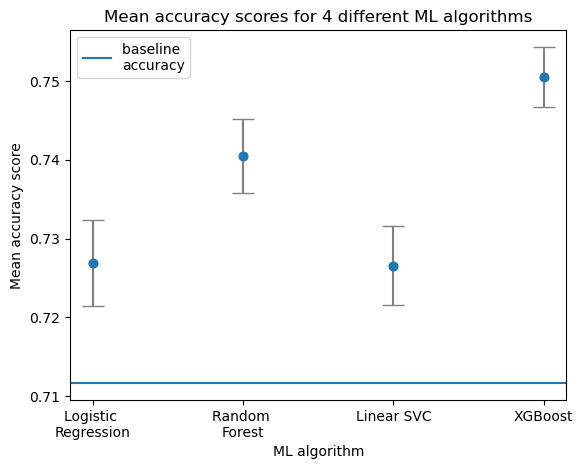

In [233]:
all_mean_accs = [mean_lr_acc,mean_rf_acc,mean_svc_acc,mean_xgb_acc]
all_std_accs = [std_lr_acc,std_rf_acc,std_svc_acc,std_xgb_acc]
labels = ['Logistic \nRegression','Random \nForest',
          'Linear SVC','XGBoost']

baseline_acc_score_avg = np.mean([baseline_mean_lr_acc,
                                  baseline_mean_rf_acc,
                                  baseline_mean_svc_acc,
                                  baseline_mean_xgb_acc])

plt.scatter(labels,all_mean_accs)
plt.errorbar(labels,all_mean_accs,yerr=all_std_accs,fmt='o',ecolor='grey',capsize=8)
plt.axhline(baseline_acc_score_avg,label='baseline \naccuracy')
plt.ylabel('Mean accuracy score')
plt.xlabel('ML algorithm')
plt.title('Mean accuracy scores for 4 different ML algorithms')
plt.legend()
plt.savefig('../figures/mean_std_acc_all_models.png',dpi=300)
plt.show()

Confusion Matrix

In [128]:
test_sets = test_sets_xgb
for i in range(len(best_models_xgb)):
    xgb = best_models_xgb[i]
    x_test = test_sets[i].loc[:,
                              test_sets[i].columns != 'y_true']
    y_pred = xgb.predict(x_test,
                         iteration_range=(
                             0,xgb.best_iteration+1))
    test_sets[i]['y_pred'] = y_pred
    
combined_df = test_sets[0].append([test_sets[1],
                                   test_sets[2],
                                   test_sets[3],
                                   test_sets[4]],
                                  ignore_index=False)

In [237]:
print(combined_df.shape)
combined_df.to_csv('../results/combined_test_set_with_predictions.csv')

(48155, 48)


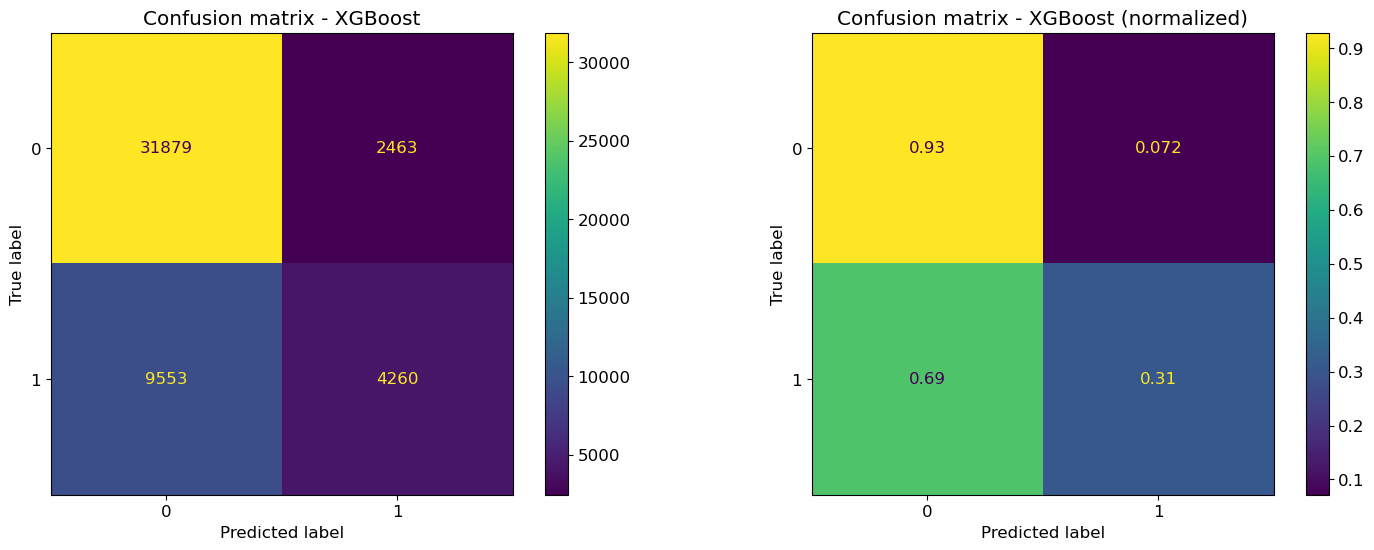

Accuracy: 0.7504724327691829
Precision: 0.6336456938866577
Recall: 0.3084051256063129


In [131]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

plt.rcParams.update({'font.size': 12})
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

cm = confusion_matrix(combined_df['y_true'],
                      combined_df['y_pred'])
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax=ax1)
ax1.set_title('Confusion matrix - XGBoost')

cm_norm = confusion_matrix(combined_df['y_true'],
                           combined_df['y_pred'],
                           normalize='true')
disp = ConfusionMatrixDisplay(cm_norm)
disp.plot(ax=ax2)
ax2.set_title('Confusion matrix - XGBoost (normalized)')
plt.savefig('../figures/results_confusion_matrix.png',dpi=300)
plt.show()

print('Accuracy:',accuracy_score(combined_df['y_true'],combined_df['y_pred']))
print('Precision:',precision_score(combined_df['y_true'],combined_df['y_pred'],pos_label='Y'))
print('Recall:',recall_score(combined_df['y_true'],combined_df['y_pred'],pos_label='Y'))

## Interpretability


### Global Feature Importance
#### XGBoost Metrics
XGBoost implements 5 different feature importance metrics. I will calculate all 5 metrics and create figures showing the top 10 most important features for each metric.

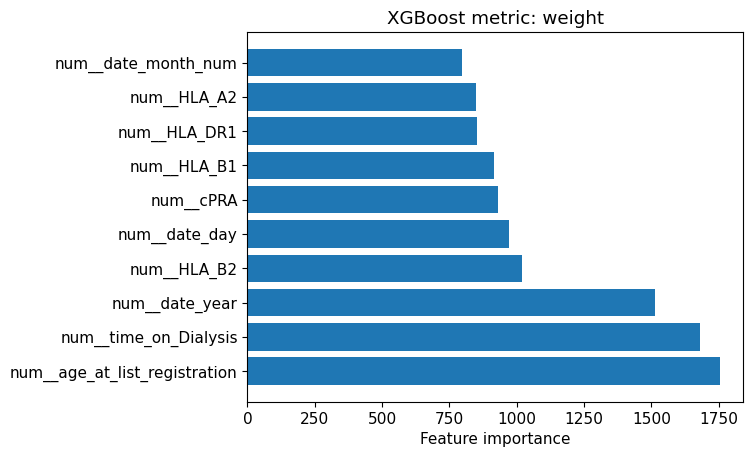

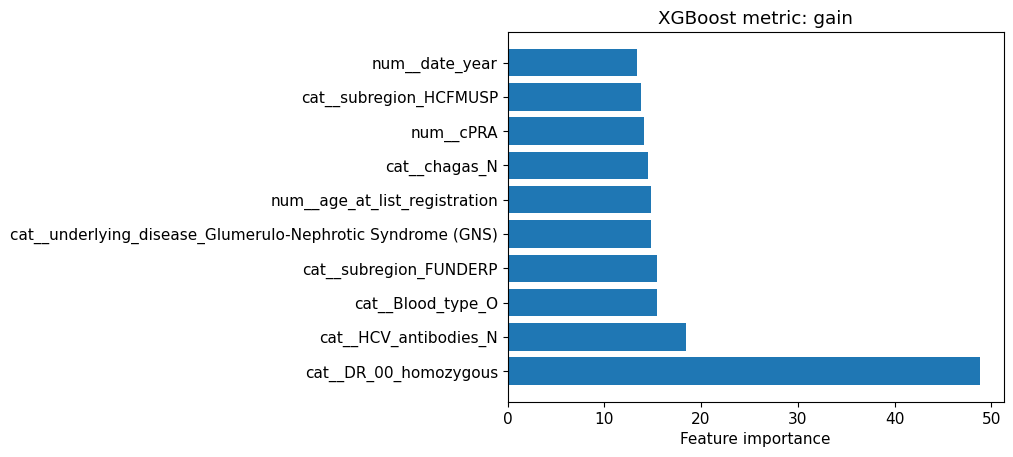

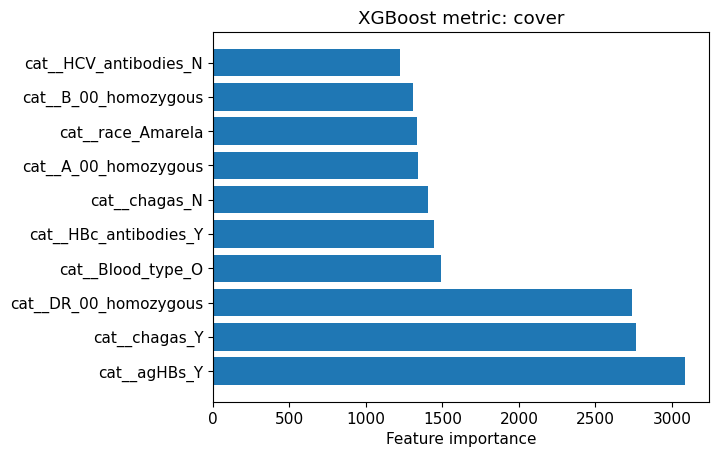

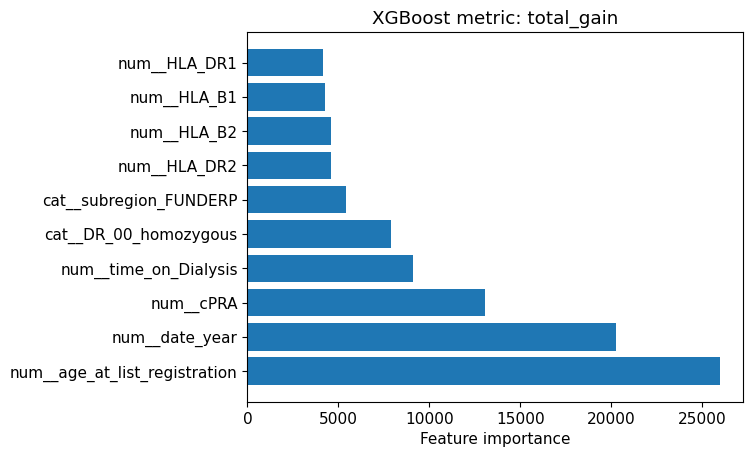

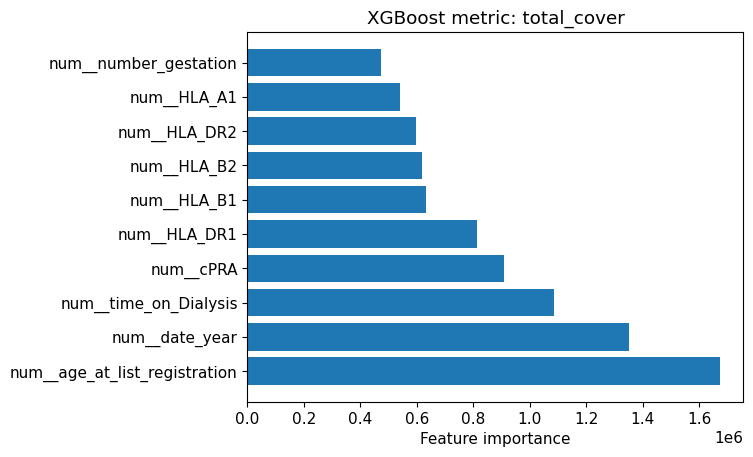

In [135]:
best_score_index = np.argmax(test_accuracies_xgb)
model = best_models_xgb[best_score_index]

options = ['weight','gain','cover','total_gain','total_cover']
for t in options:
    result = model.get_booster().get_score(importance_type=t)
    values = sorted(result.values(),reverse=True)[:10]
#     print('values:',values)
    keys = sorted(result,key=result.get,reverse=True)[:10]
#     print('features:',keys)
    
    plt.rcParams.update({'font.size': 11})

    fig,ax = plt.subplots()
    plt.barh(range(len(values)),values)
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(keys)
    plt.title('XGBoost metric: '+t)
    plt.xlabel('Feature importance')
    plt.savefig('../figures/results_xgb_ftrimportance_{}.png'.format(t),dpi=300)
    plt.show()

#### SHAP values for global feature importance
Now, using shap values to calculate global feature importance.

In [136]:
import shap

x_test_for_shap = test_sets_xgb[best_score_index]
x_test_for_shap.drop(columns=['y_true','y_pred'],inplace=True)

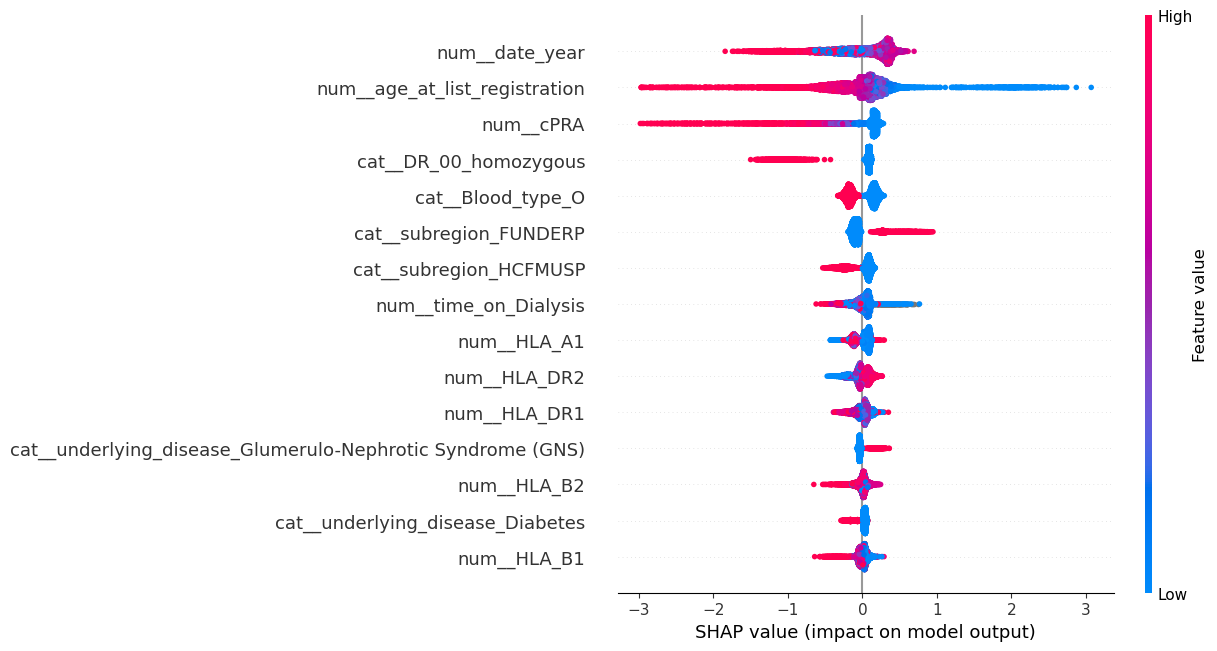

In [235]:
shap.initjs()
# create the explainer object with the XGBoost model
explainer = shap.TreeExplainer(model)

# calculate shap values
shap_values = explainer.shap_values(x_test_for_shap)
# print(np.shape(shap_values))
shap.summary_plot(shap_values,
                  x_test_for_shap,
                  max_display=15,
                  feature_names=x_test_for_shap.columns,
                  show=False)
plt.gcf().axes[-1].set_aspect(75)
plt.gcf().axes[-1].set_box_aspect(75)
plt.savefig('../figures/results_shap_summary.png',dpi=300)
plt.show()

#### Permutation feature importance

Using the preprocessed test feature matrix.

In [227]:
np.random.seed(2)
nr_runs = 5
perm_imp_x_test = df_test.drop(columns='y_true',inplace=False)
ftrs = perm_imp_x_test.columns
scores = np.zeros([len(ftrs),nr_runs])

# model is the best xgb model  #    <-------------------------- FILL THIS IN WITH BEST MODEL!!!!!!!

for i in range(len(ftrs)):
    print('shuffling '+str(ftrs[i]))
    accuracy_scores = []
    for j in range(nr_runs):
        X_test_shuffled = perm_imp_x_test.copy()
        X_test_shuffled[ftrs[i]] = np.random.permutation(perm_imp_x_test[ftrs[i]].values)
        y_test_shuffled_pred = model.predict(X_test_shuffled)
        accuracy_scores.append(accuracy_score(y_test,y_test_shuffled_pred))
    print('   shuffled test score:',np.around(np.mean(accuracy_scores),3),
          '+/-',np.around(np.std(accuracy_scores),3))
    scores[i] = accuracy_scores

shuffling num__age_at_list_registration
   shuffled test score: 0.732 +/- 0.001
shuffling num__time_on_Dialysis
   shuffled test score: 0.764 +/- 0.001
shuffling num__number_transfusion
   shuffled test score: 0.768 +/- 0.001
shuffling num__number_gestation
   shuffled test score: 0.768 +/- 0.001
shuffling num__cPRA
   shuffled test score: 0.757 +/- 0.003
shuffling num__HLA_A1
   shuffled test score: 0.767 +/- 0.001
shuffling num__HLA_A2
   shuffled test score: 0.766 +/- 0.001
shuffling num__HLA_B1
   shuffled test score: 0.766 +/- 0.001
shuffling num__HLA_B2
   shuffled test score: 0.766 +/- 0.001
shuffling num__HLA_DR1
   shuffled test score: 0.765 +/- 0.001
shuffling num__HLA_DR2
   shuffled test score: 0.763 +/- 0.001
shuffling num__number_prior_transplant
   shuffled test score: 0.769 +/- 0.0
shuffling num__date_year
   shuffled test score: 0.742 +/- 0.001
shuffling num__date_month_num
   shuffled test score: 0.767 +/- 0.001
shuffling num__date_day
   shuffled test score: 0.766 +/

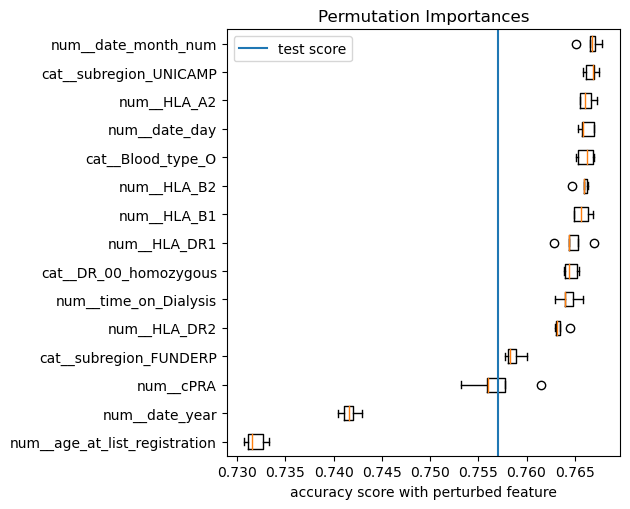

In [229]:
#sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1][:-15]
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::1][:15]

test_score = test_accuracies_xgb[best_score_index] 
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(6.4,5.2))
plt.boxplot(scores[sorted_indcs].T,labels=ftrs[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title('Permutation Importances')
plt.xlabel('accuracy score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/global_permutation_importance.png',dpi=300)
plt.show()

### Local Feature Importance
#### SHAP force plots

Below is a patient whose true and predicted classes were 1 (received a transplant).

In [172]:
indices = [10,100,200]

print(explainer.expected_value)
shap.force_plot(explainer.expected_value, 
                shap_values[indices[0]], 
                features = x_test_for_shap.iloc[indices[0]],
                feature_names = x_test_for_shap.columns)

-0.9579395


Below is a patient whose true and predicted classes were 0 (did not receive a transplant).

In [173]:
shap.force_plot(explainer.expected_value, 
                shap_values[indices[1]], 
                features = x_test_for_shap.iloc[indices[1]],
                feature_names = x_test_for_shap.columns)

Below is a patient whose true and predicted classes were 0 (did not receive a transplant).

In [149]:
shap.force_plot(explainer.expected_value, 
                shap_values[indices[2]], 
                features = x_test_for_shap.iloc[indices[2]],
                feature_names = x_test_for_shap.columns)